<img src="../../share/skience2020_logo.png"
     alt="Markdown Monster icon"
     width="300"
     style="float: right; margin-right: 100px;" />
     
# Nonlinear optimisation in 2D

##### Author:
* Andreas Fichtner (email: andreas.fichtner@erdw.ethz.ch)

---

The following notebook provides examples of several nonlinear optimisation methods (steepest descent, Newton, different conjugate-gradient variants, BFGS, and L-BFGS) applied to various 2D test functions.

## 0. Import some Python packages

We begin by importing some Python packages for matrix-vector operations, for plotting, and for a collection of 2D test functions.

In [7]:
# Some Python packages.

import matplotlib.pyplot as plt
import numpy as np
import test_functions as f

# Set some parameters to make plots nicer.
plt.rcParams["font.family"] = "serif"
# plt.rcParams["figure.figsize"] = [9.6, 7.2]
plt.rcParams.update({'font.size': 30})

## 1. Input parameters and initialisation

In the following, we set a few input parameters, including the initial coordinates, the initial step length for the line search, the line search method, the optimisation method, and the test function we would like to use. Currently implemented test functions are:

\begin{equation}
f(x,y) = (1.0-x)^2 + 100.0 *(y-x^2)^2\,,\qquad \text{(Rosenbrock function)}\,,
\end{equation}

\begin{equation}
f(x,y) = x^2 + y^2 + xy\,,\qquad \text{(quadratic function)}\,,
\end{equation}

\begin{equation}
f(x,y) = (x^2 + y - 11.0)^2 + (x + y^2 - 7.0)^2\,,\qquad \text{(Himmelblau function)}\,,
\end{equation}

\begin{equation}
f(x,y) = (x-2.0)^4 + (x - 2.0y)^2\,,\qquad \text{(Bazaraa-Shetty function)}\,.
\end{equation}

In [2]:
# Input parameters ------------------------------------------------------------------------

# Initial coordinates.
x0=-0.5
y0=0.5

# Initial step length (also serves as step length increment in exhaustive, full line search).
s_min=0.001

# Test function ('rosenbrock', 'quadratic', 'himmelblau', 'bazaraa-shetty').
function='rosenbrock'

# Line search method ('quadratic', 'full')
ls_method='full'

# Number of iterations.
nit=20

# Print misfit.
print_misfit=False

# Save figures.
save_figure=True

# Initialisations -------------------------------------------------------------------------

# Useful plotting domains and optima for the test functions.
if function=='quadratic':
    xmin=-1.1
    xmax=1.1
    ymin=-1.5
    ymax=1.5
    xopt=0.0
    yopt=0.0
elif function=='rosenbrock':
    xmin=-1.1
    xmax=1.1
    ymin=-1.5
    ymax=1.5
    xopt=1.0
    yopt=1.0
elif function=='himmelblau':
    xmin=-5.5
    xmax=5.5
    ymin=-5.5
    ymax=7.5
    xopt=-2.80511809
    yopt=3.13131252
    # There are three other minima!
elif function=='bazaraa-shetty':
    xmin=1.5
    xmax=2.6
    ymin=0.8
    ymax=1.3
    xopt=2.0
    yopt=1.0

# Make domain for plotting.
xp,yp=np.meshgrid(np.linspace(xmin,xmax,100),np.linspace(ymin,ymax,100))

# Initialise coordinates. ---------------------------------------------------------------
opt=np.matrix([[xopt],[yopt]])

## 2. Line search and updating

Before implementing any specific optimisation method, we write a little helper function that performs a line search and updates the current position. The function takes the current position $\mathbf{x}$, the descent direction $\mathbf{h}$, and the initial step length $s$.

Two line search options are available: 

(1) A *full* line search where a large number of step lengths are tested. In this case, the initial step length $s$ also serves as the step length increment.

(2) A *quadratic* line search where the misfit along the search direction is approximated by a quadratic curve fitted to three trial step lengths.

In [3]:
def line_search(x,h,s,function="rosenbrock",ls_method="quadratic"):
    
    # Quadratic interpolation. ---------------------------
    if ls_method=="quadratic":
        
        # Trial models. 
        x0=x
        chi0=f.f(x0[0,0],x0[1,0],function)
        
        s1=s
        x1=x+s1*h
        chi1=f.f(x1[0,0],x1[1,0],function)
        
        s2=2.0*s
        x2=x+s2*h
        chi2=f.f(x2[0,0],x2[1,0],function)
        
        #- Polynomial coefficients and optimum. 
        
        a=chi0
        c=(s2*(chi1-chi0)+s1*(chi0-chi2))/(s1*s1*s2-s1*s2*s2)
        b=(chi1-chi0-c*s1*s1)/s1
        
        s_opt=-b/(2.0*c)
        
        # Update.
        x_opt=x+s_opt*h
        chi_opt=f.f(x_opt[0,0],x_opt[1,0],function)
        
    # Full search along the line. ------------------------
    if ls_method=="full":
        
        # Initialise.
        chi_opt=f.f(x[0,0],x[1,0],function)
        x_opt=x
        s_opt=s
        
        # March through many trial step lengths.
        x_test=x+s*h
        chi_test=f.f(x_test[0,0],x_test[1,0],function)
        if chi_test>=chi_opt:
            print('minimum step length too long')
            s_opt=0.0
            x_opt=x
        else:

            # Iterate.
            while chi_test<chi_opt:
                chi_opt=chi_test
                x_opt=x_test
                s_opt+=s
                x_test=x+s_opt*h
                chi_test=f.f(x_test[0,0],x_test[1,0],function)
            
            # Update.
            x_opt=x+s_opt*h
            chi_opt=f.f(x_opt[0,0],x_opt[1,0],function)
            
    # Return. --------------------------------------------
    return x_opt, chi_opt, s_opt

## 3. Steepest descent

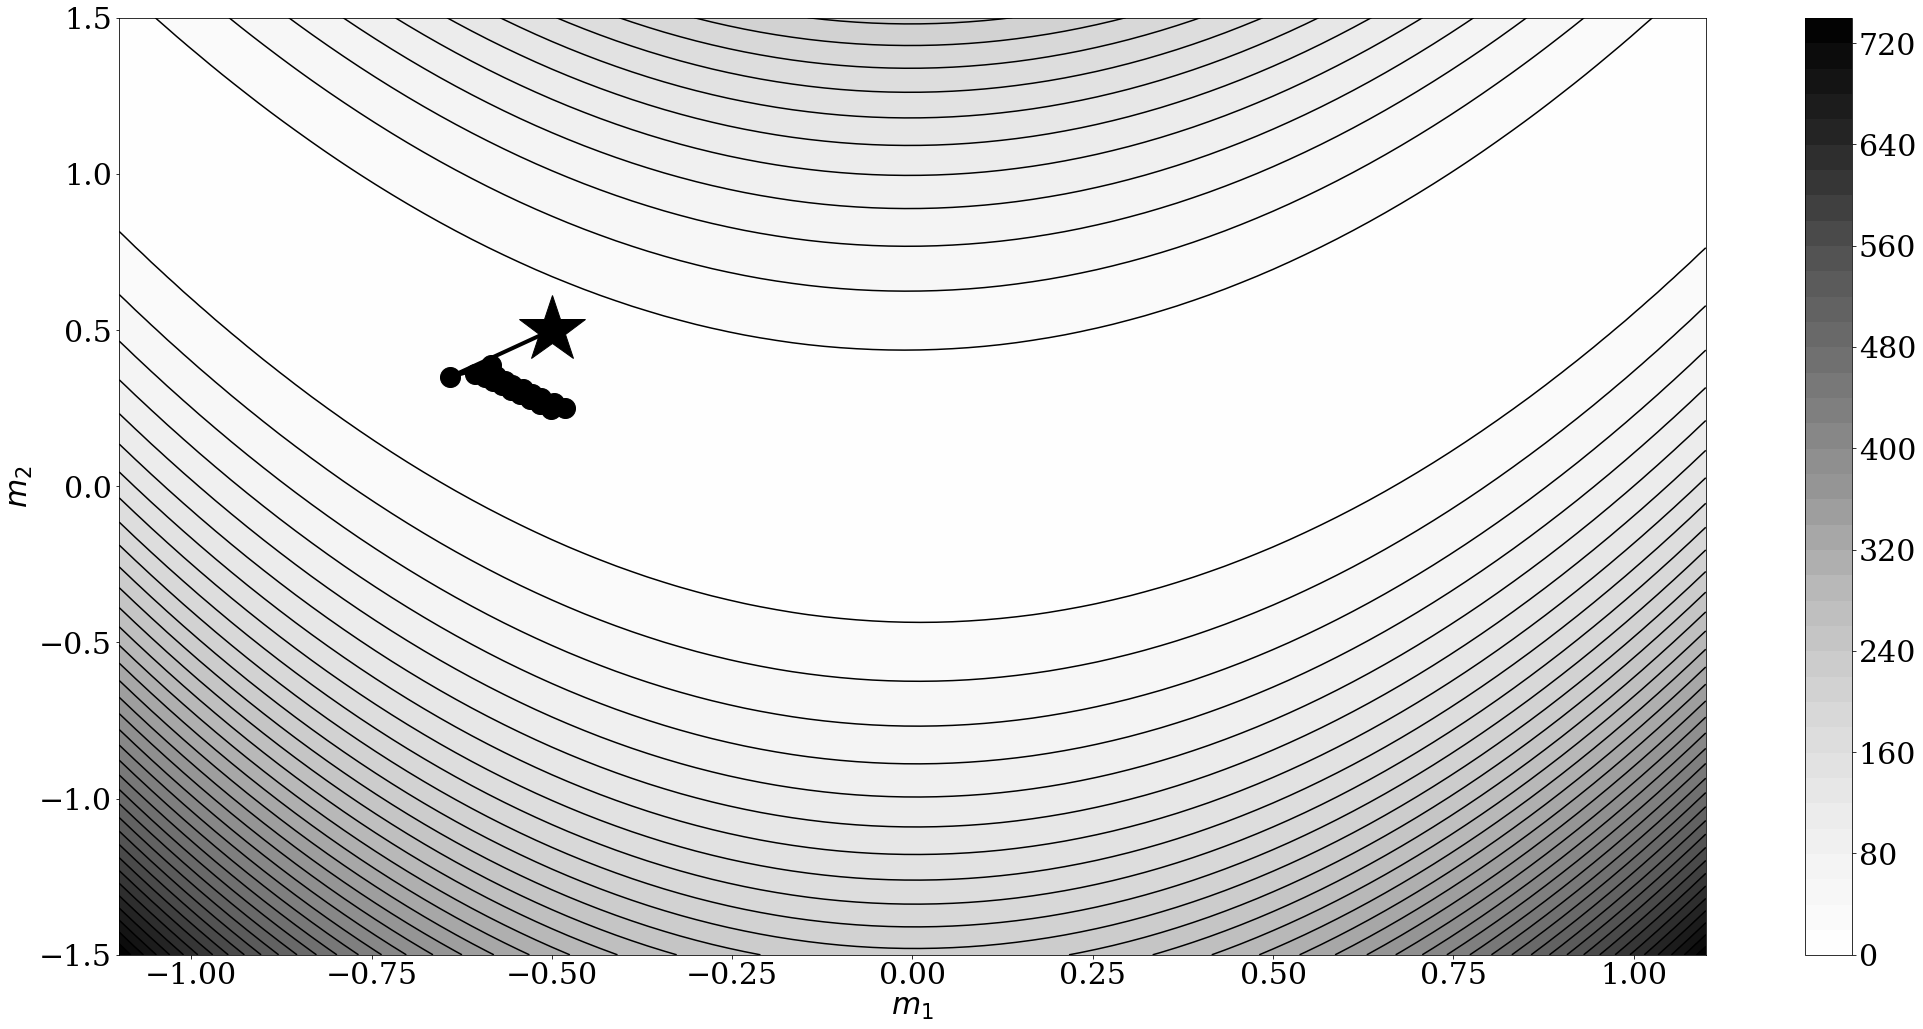

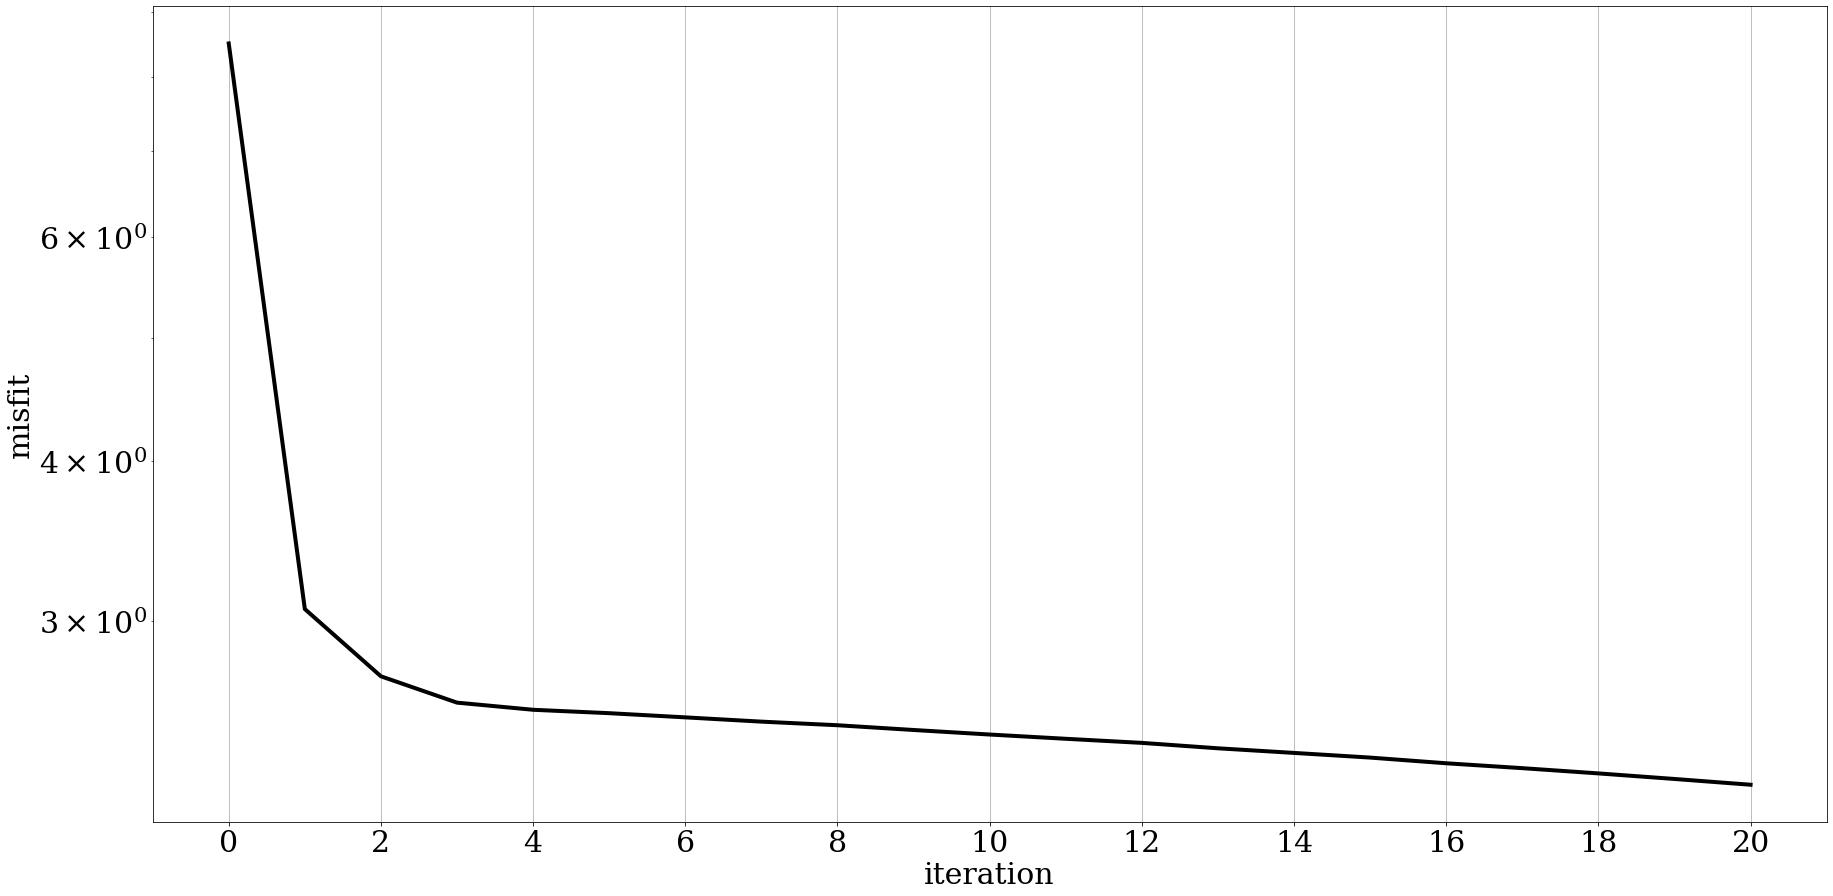

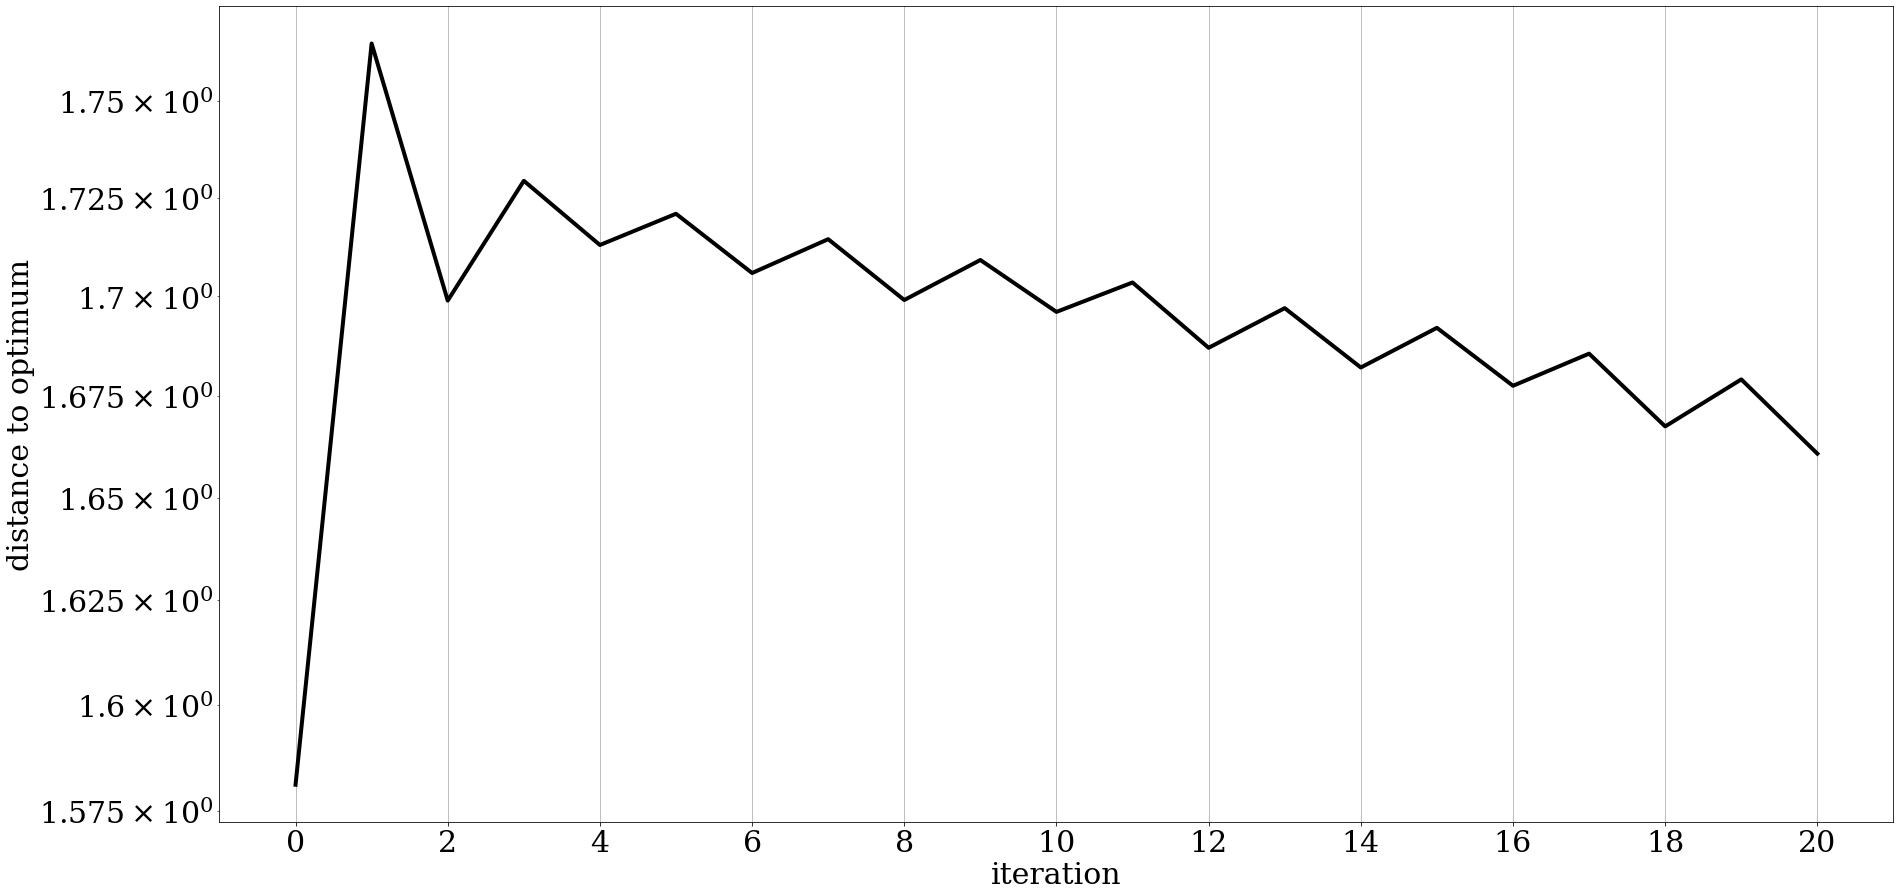

In [8]:
# Initialise coordinates and misfit. --------------------
x=np.matrix([[x0],[y0]])
chi_sd=np.zeros(nit+1)
chi_sd[0]=f.f(x[0,0],x[1,0],function)
diff_sd=np.zeros(nit+1)
diff_sd[0]=np.linalg.norm(x-opt)
plt.subplots(1, figsize=(30,15))
plt.plot(x[0,0],x[1,0],'k*',markersize=70)
if print_misfit: print('iteration=0, misfit=%f' % chi_sd[0])

s=s_min
    
# Iterate. ----------------------------------------------
for it in range(nit):
    
    J=f.J(x[0,0],x[1,0],function)
    x_new, chi_sd[it+1], s_opt = line_search(x,-J,s,function,ls_method)
    if s_opt==0.0: s=s/2.0
    plt.plot(x_new[0,0],x_new[1,0],'ko',markersize=20)
    plt.plot((x[0,0],x_new[0,0]),(x[1,0],x_new[1,0]),'k',linewidth=4)
    x=x_new
    diff_sd[it+1]=np.linalg.norm(x-opt)
        
    if print_misfit: print('iteration=%d, misfit=%f' % (it+1, chi_sd[it+1]))

# Plot trajectory. --------------------------------------
f.f(xp,yp,function,plot=True)
if save_figure==True: plt.savefig("path_sd.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),chi_sd,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('misfit')
plt.grid()
if save_figure==True: plt.savefig("misfit_sd.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),diff_sd,'k',linewidth=4)
plt.xticks(range(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('distance to optimum')
plt.grid()
if save_figure==True: plt.savefig("distance_sd.png",format='png')
plt.show()

## 4. Newton's method

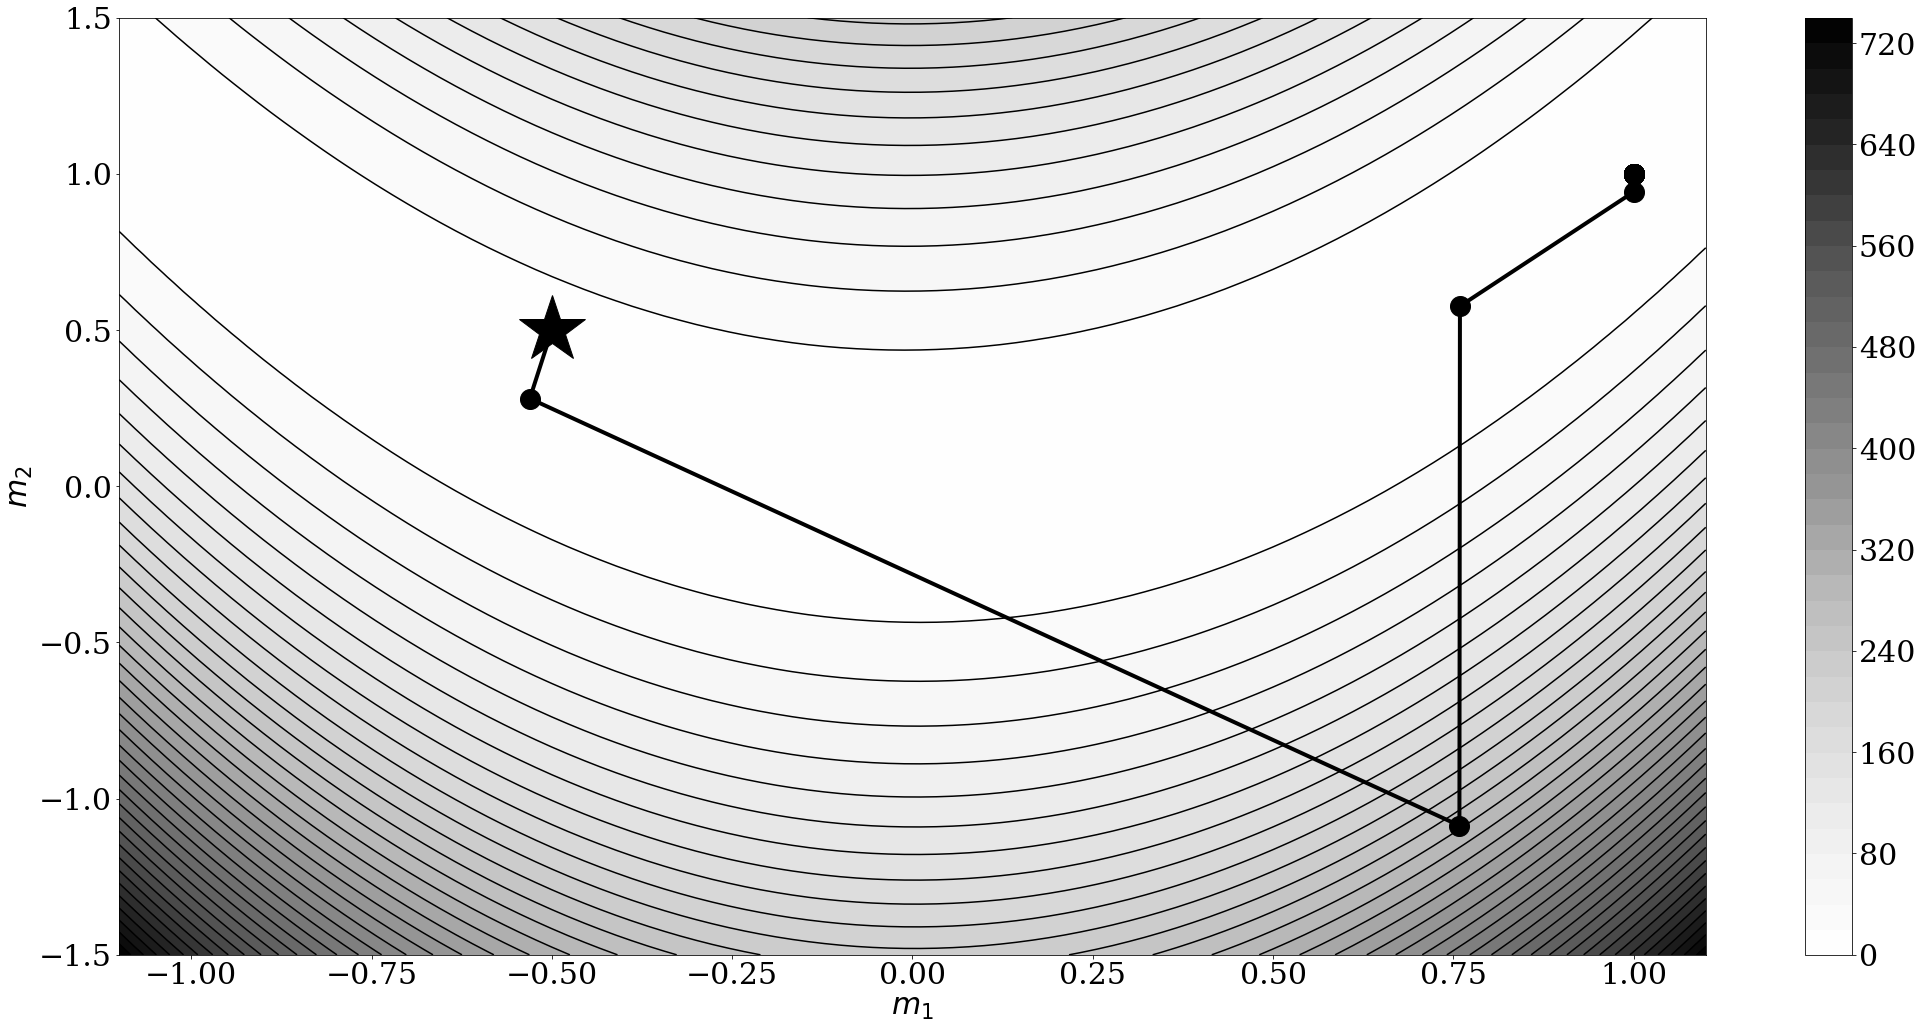

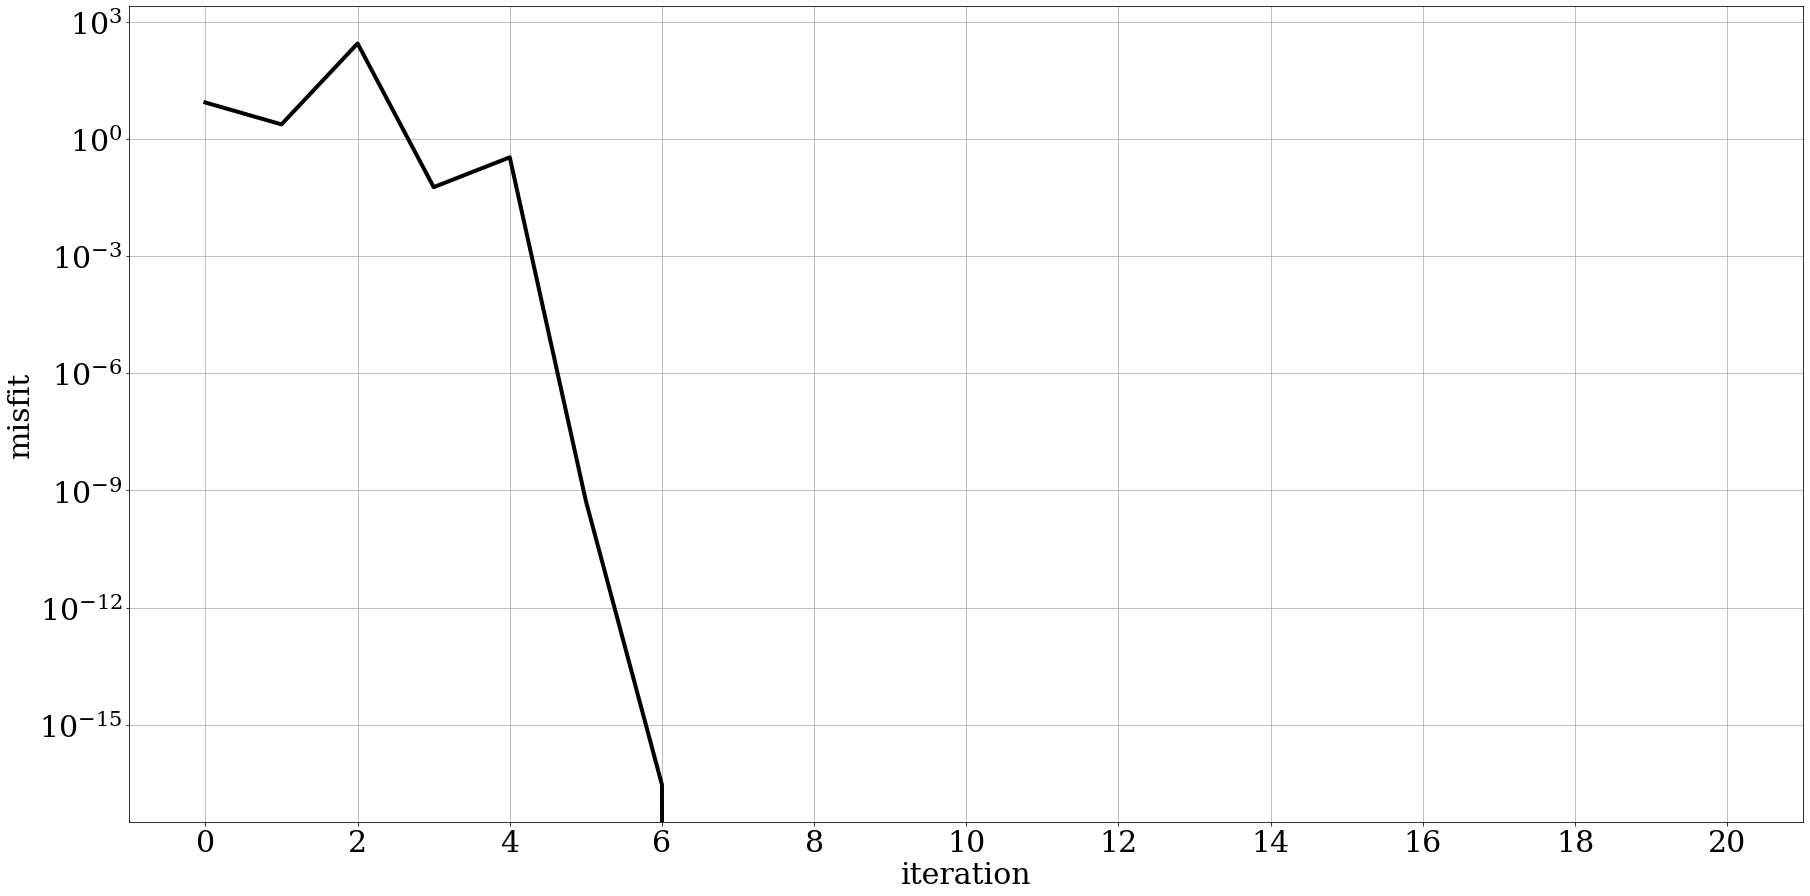

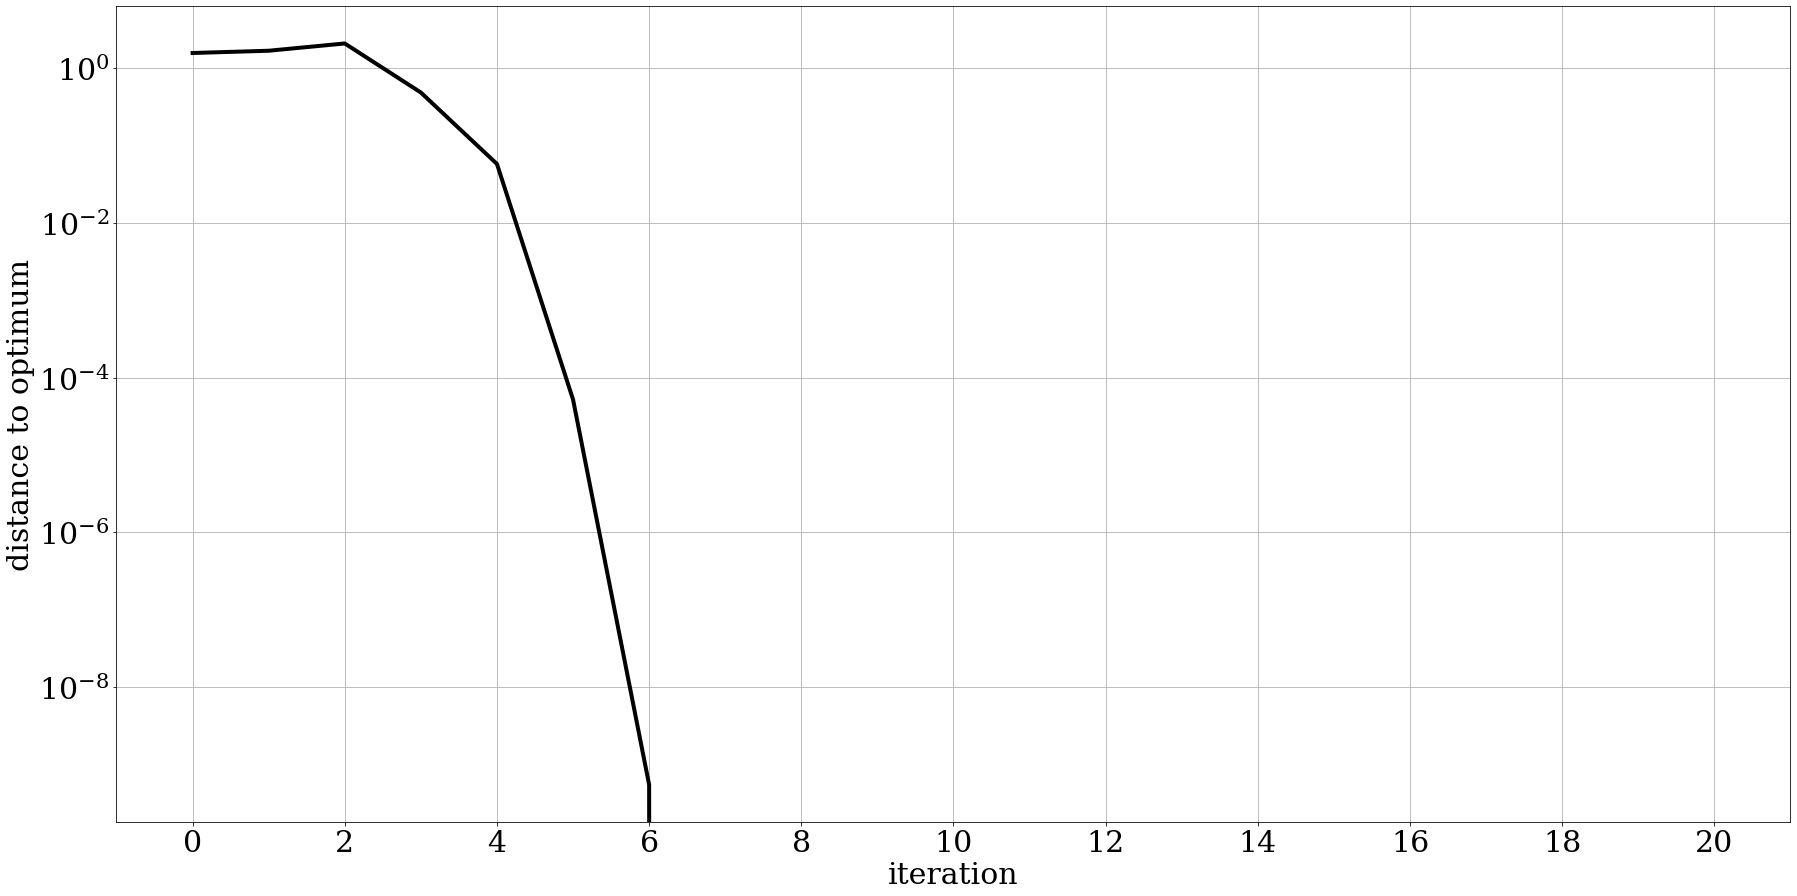

In [9]:
# Initialise coordinates and misfit. --------------------
x=np.matrix([[x0],[y0]])
chi_ne=np.zeros(nit+1)
chi_ne[0]=f.f(x[0,0],x[1,0],function)
diff_ne=np.zeros(nit+1)
diff_ne[0]=np.linalg.norm(x-opt)
plt.subplots(1, figsize=(30,15))
plt.plot(x[0,0],x[1,0],'k*',markersize=70)
if print_misfit: print('iteration=0, misfit=%f' % chi_ne[0])

# Iterate. ----------------------------------------------
for it in range(nit):
    
    J=f.J(x[0,0],x[1,0],function)
    H=f.H(x[0,0],x[1,0],function)
    h=-np.linalg.inv(H)*J
    x_new=x+h
    chi_ne[it+1]=f.f(x_new[0,0],x_new[1,0],function)
    plt.plot(x_new[0,0],x_new[1,0],'ko',markersize=20)
    plt.plot((x[0,0],x_new[0,0]),(x[1,0],x_new[1,0]),'k',linewidth=4)
    x=x_new
    diff_ne[it+1]=np.linalg.norm(x-opt)
        
    if print_misfit: print('iteration=%d, misfit=%f' % (it+1, chi_ne[it+1]))

# Plot trajectory. --------------------------------------
f.f(xp,yp,function,plot=True)
if save_figure==True: plt.savefig("path_newton.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),chi_ne,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('misfit')
plt.grid()
if save_figure==True: plt.savefig("misfit_newton.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),diff_ne,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('distance to optimum')
plt.grid()
if save_figure==True: plt.savefig("distance_newton.png",format='png')
plt.show()

## 5. Conjugate gradients (Fletcher-Reeves)

minimum step length too long
minimum step length too long
minimum step length too long


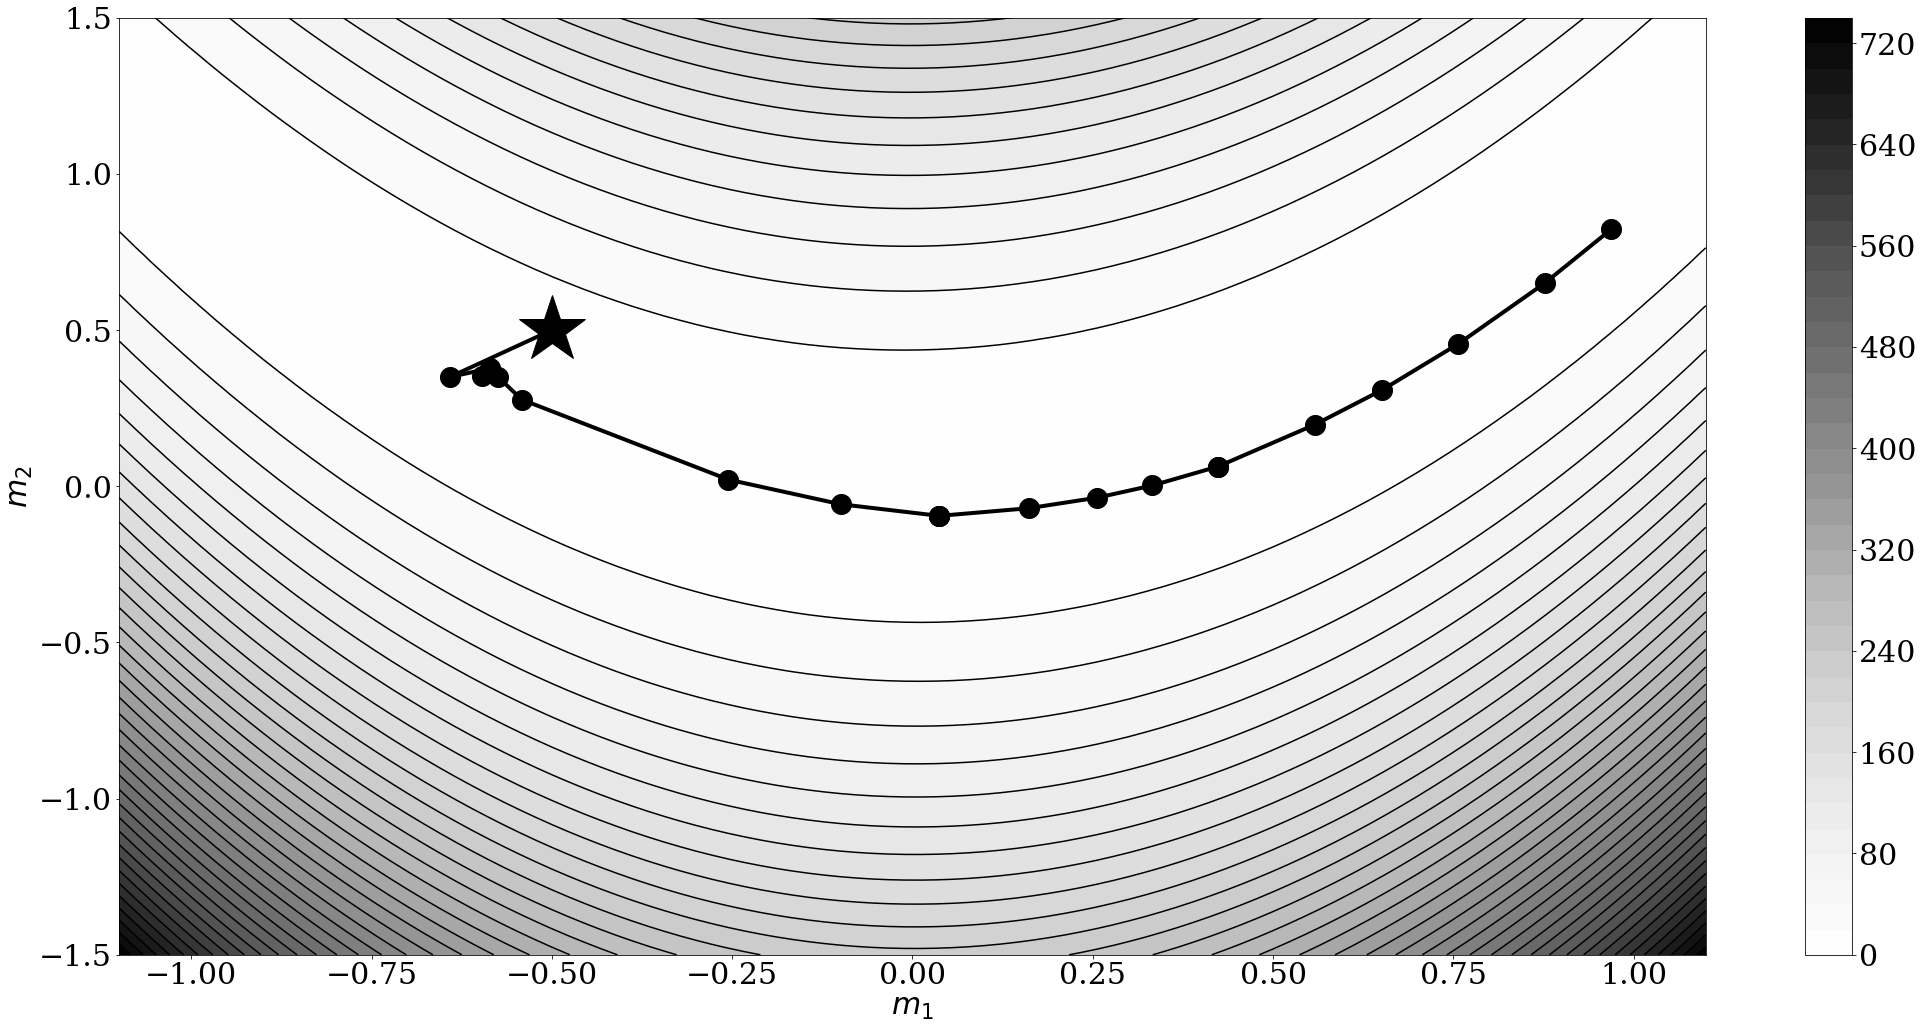

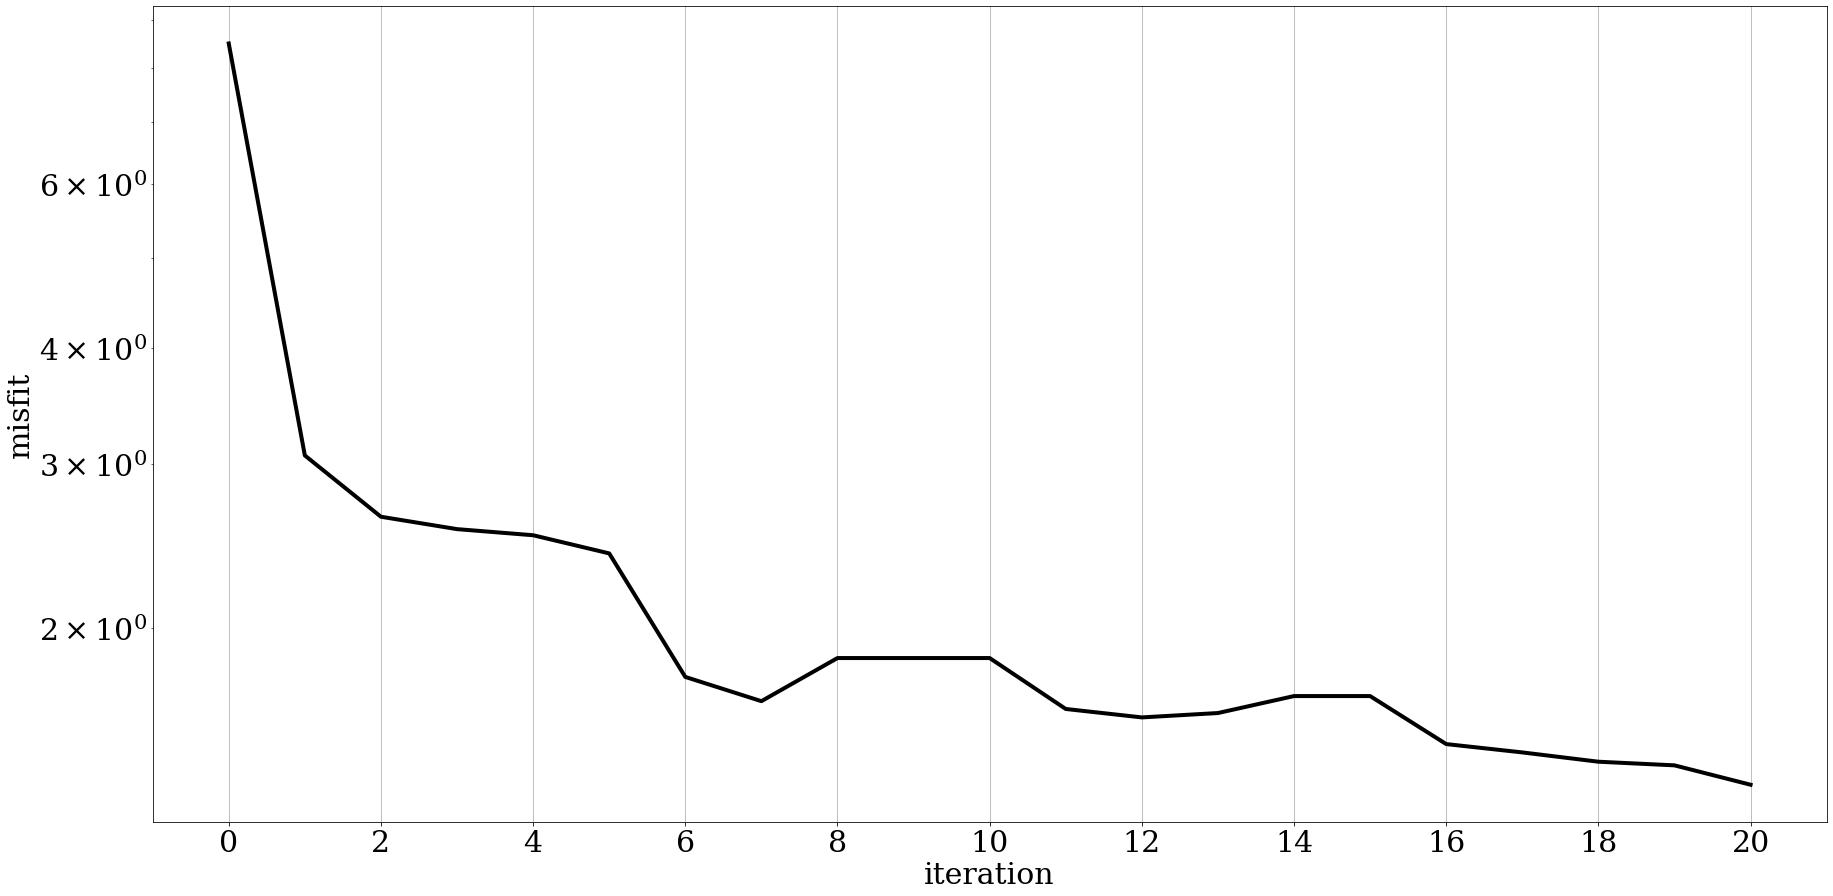

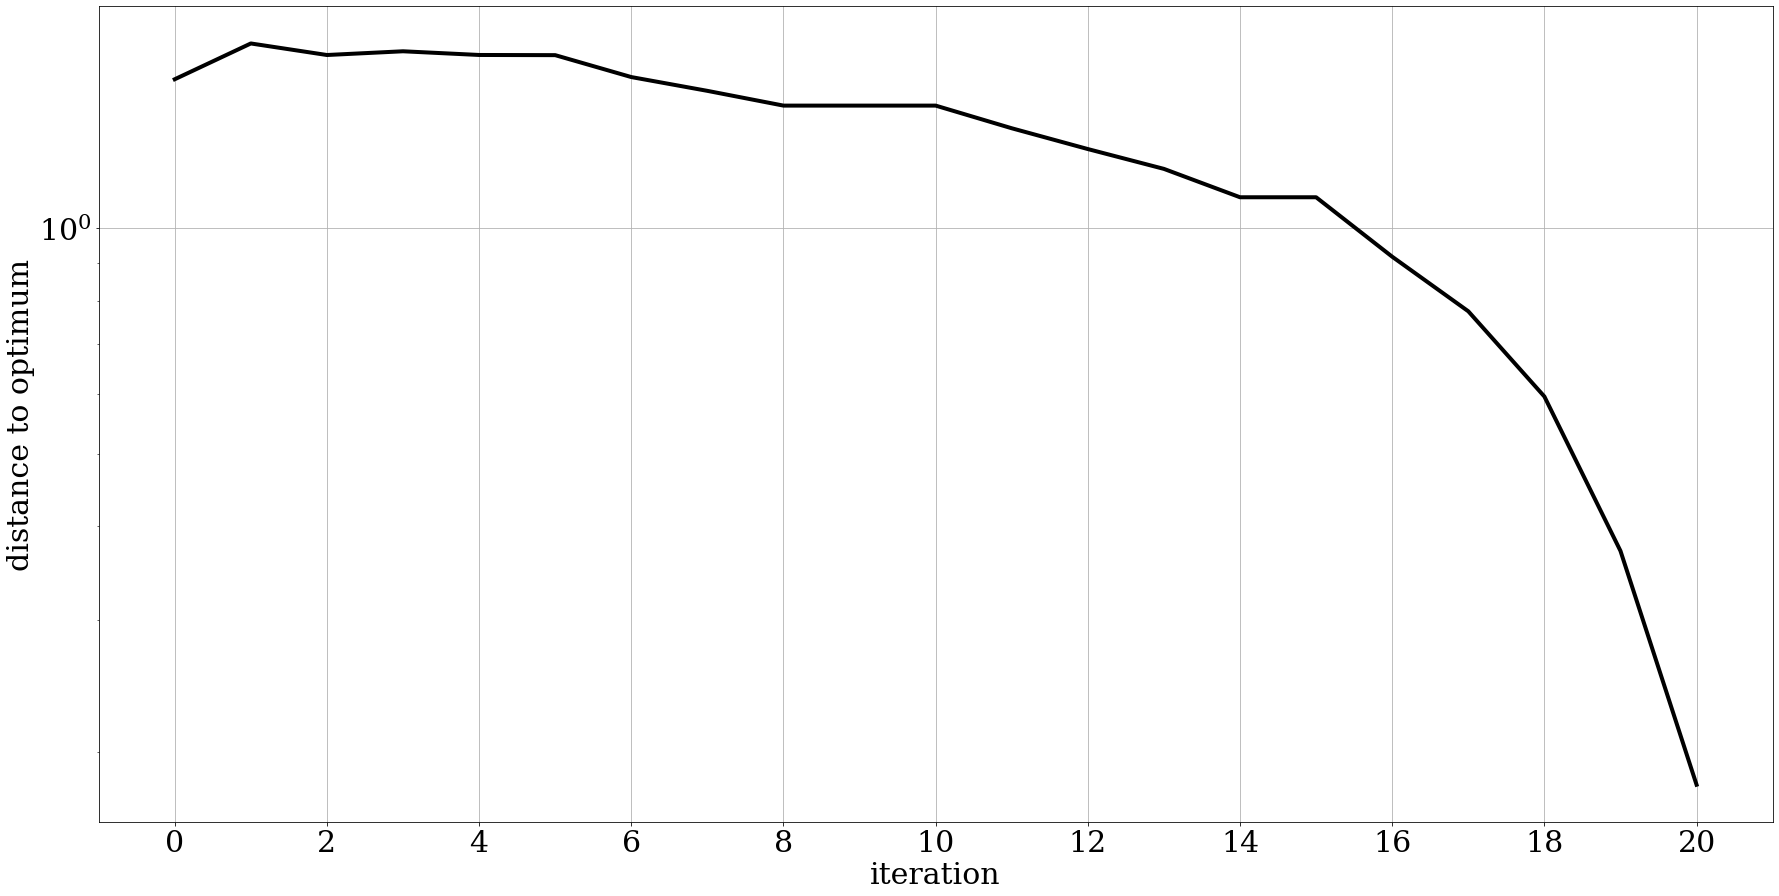

In [10]:
# Initialise coordinates and misfit. --------------------
x=np.matrix([[x0],[y0]])
chi_fr=np.zeros(nit+1)
chi_fr[0]=f.f(x[0,0],x[1,0],function)
diff_fr=np.zeros(nit+1)
diff_fr[0]=np.linalg.norm(x-opt)
plt.subplots(1, figsize=(30,15))
plt.plot(x[0,0],x[1,0],'k*',markersize=70)
if print_misfit: print('iteration=0, misfit=%f' % chi_fr[0])

s=s_min
    
# Iterate. ----------------------------------------------
for it in range(nit):
    
    if it==0:
        J=f.J(x[0,0],x[1,0],function)
        h=-J
        
    x_new, chi_fr[it+1], s_opt = line_search(x,h,s,function,ls_method)
    if s_opt==0.0: s=s/2.0
    J_new=f.J(x_new[0,0],x_new[1,0],function)
    beta=float((J_new.T*J_new)/(J.T*J))
    h=-J_new+beta*h
    
    plt.plot(x_new[0,0],x_new[1,0],'ko',markersize=20)
    plt.plot((x[0,0],x_new[0,0]),(x[1,0],x_new[1,0]),'k',linewidth=4)
    
    J=J_new
    x=x_new
    
    diff_fr[it+1]=np.linalg.norm(x-opt)
        
    if print_misfit: print('iteration=%d, misfit=%f' % (it+1, chi_fr[it+1]))

# Plot trajectory. --------------------------------------
f.f(xp,yp,function,plot=True)
if save_figure==True: plt.savefig("path_cgfr.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),chi_fr,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('misfit')
plt.grid()
if save_figure==True: plt.savefig("misfit_cgfr.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),diff_fr,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('distance to optimum')
plt.grid()
if save_figure==True: plt.savefig("distance_cgfr.png",format='png')
plt.show()

## 6. Conjugate gradients (Polak-Ribiere)

minimum step length too long
minimum step length too long


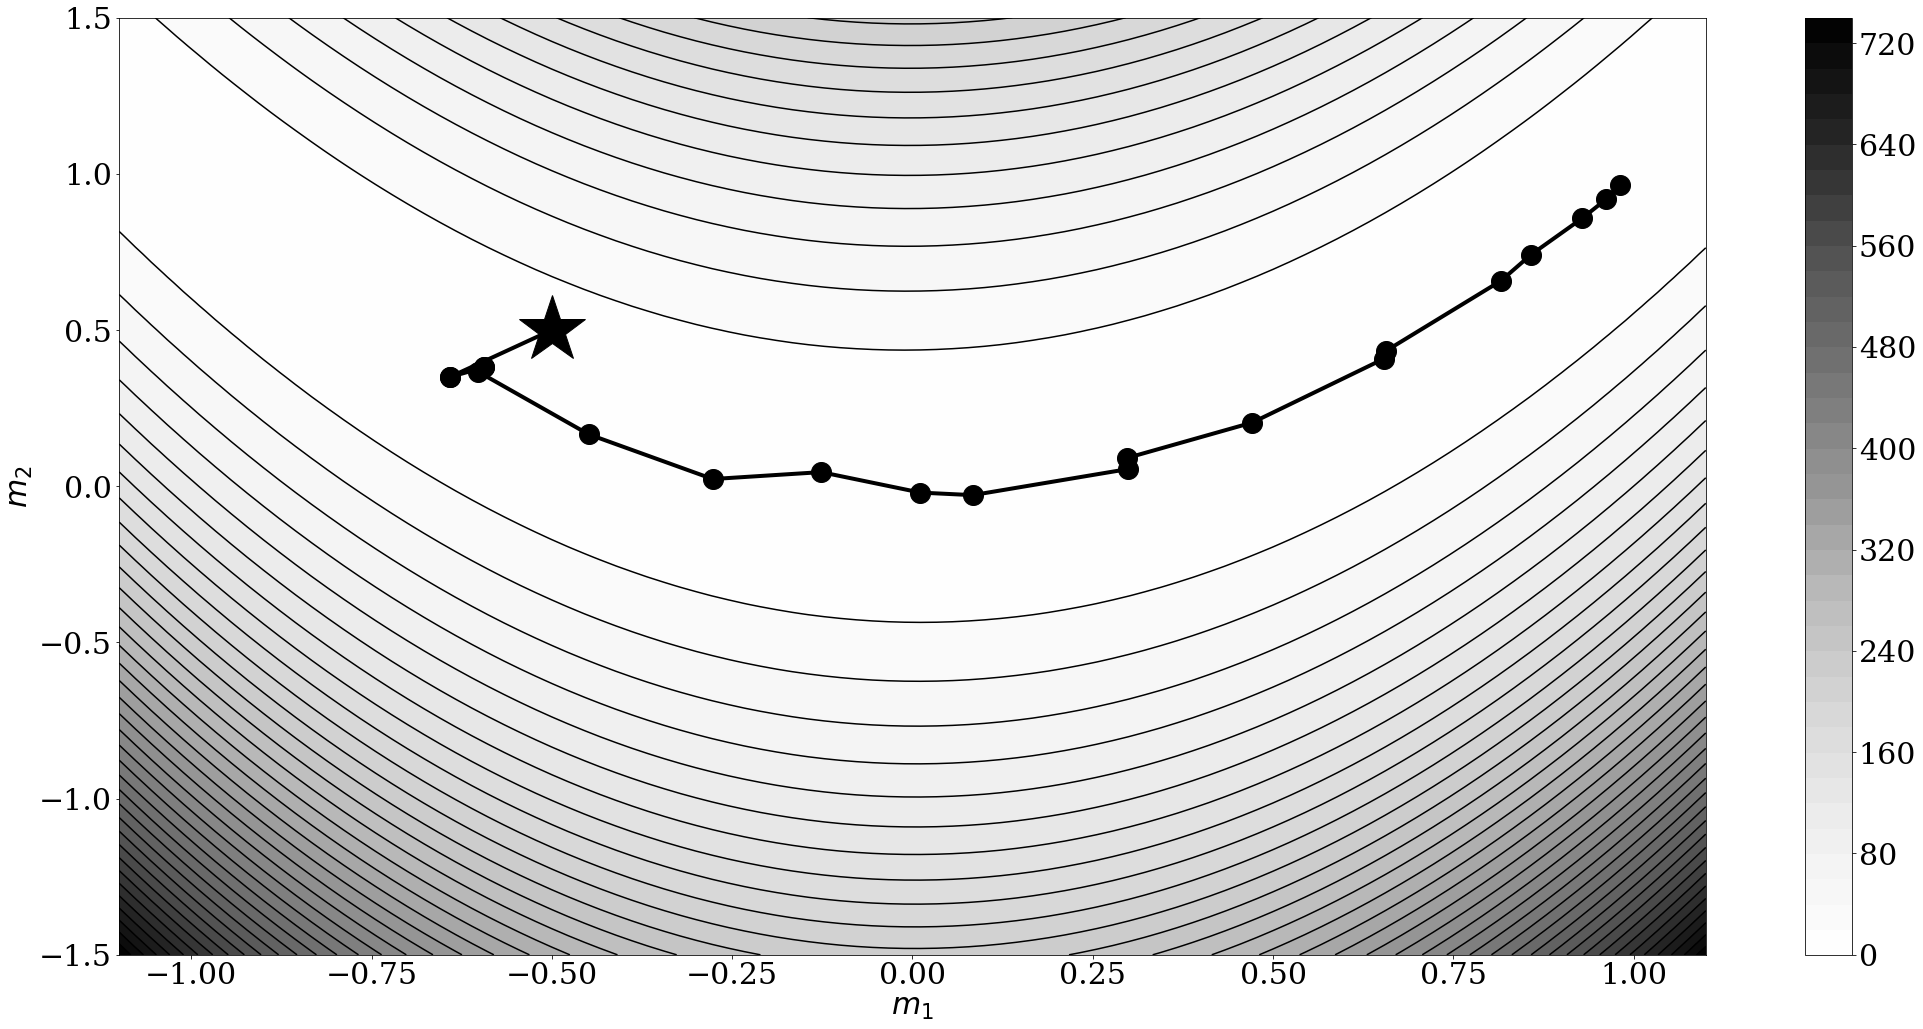

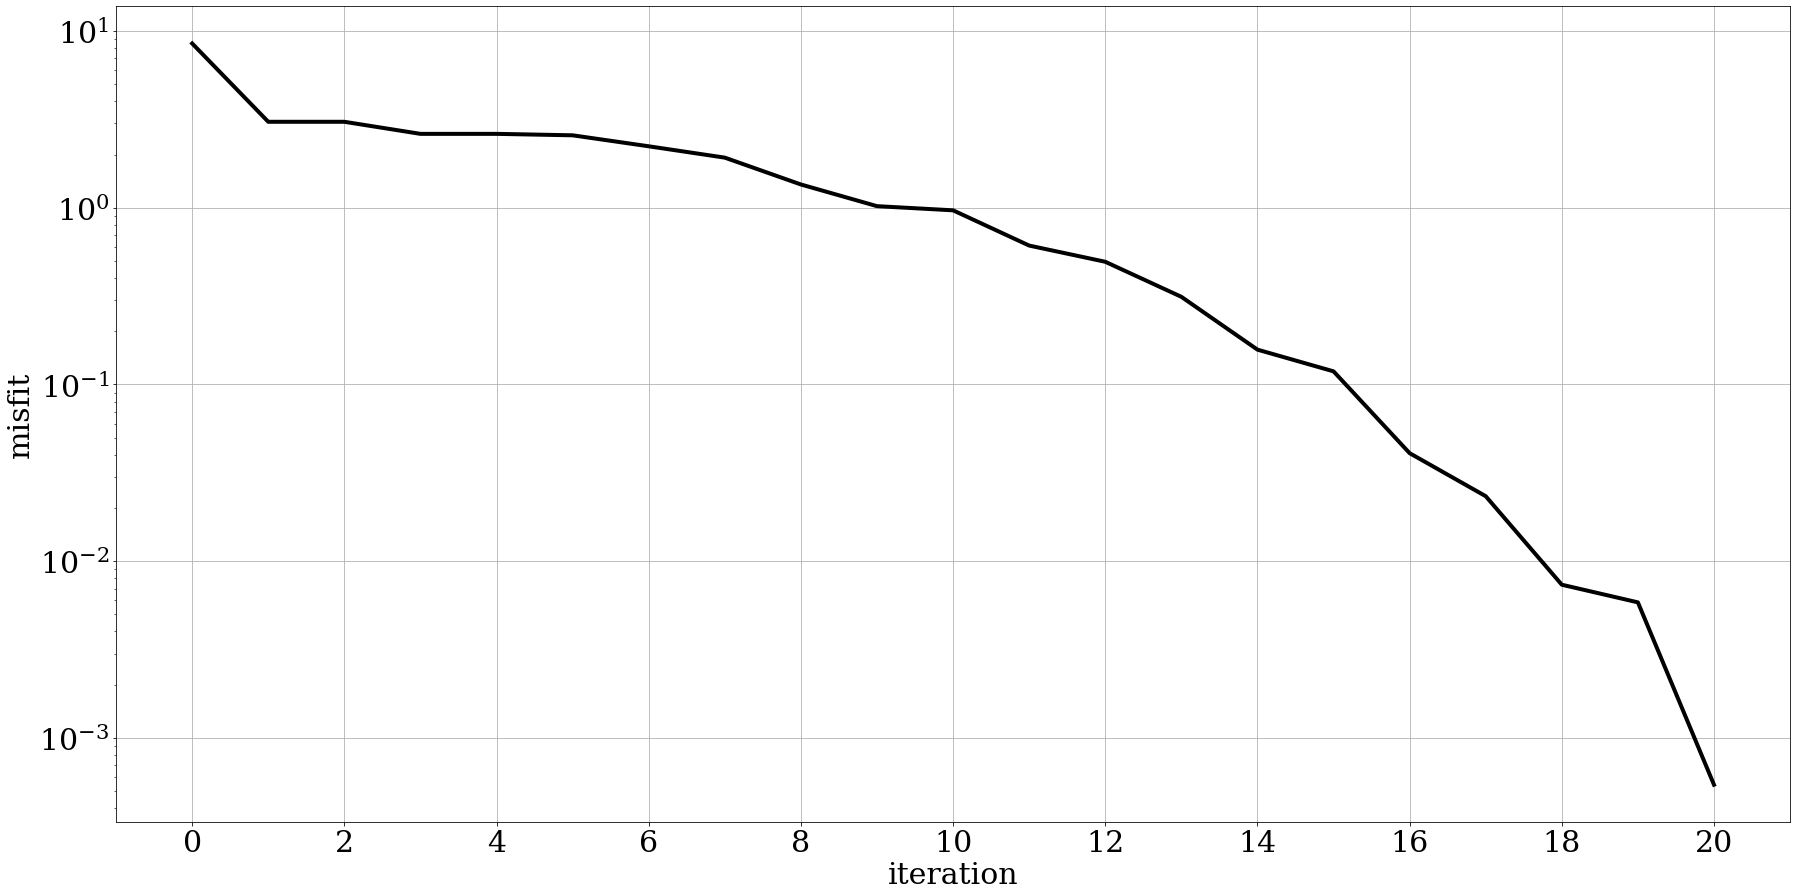

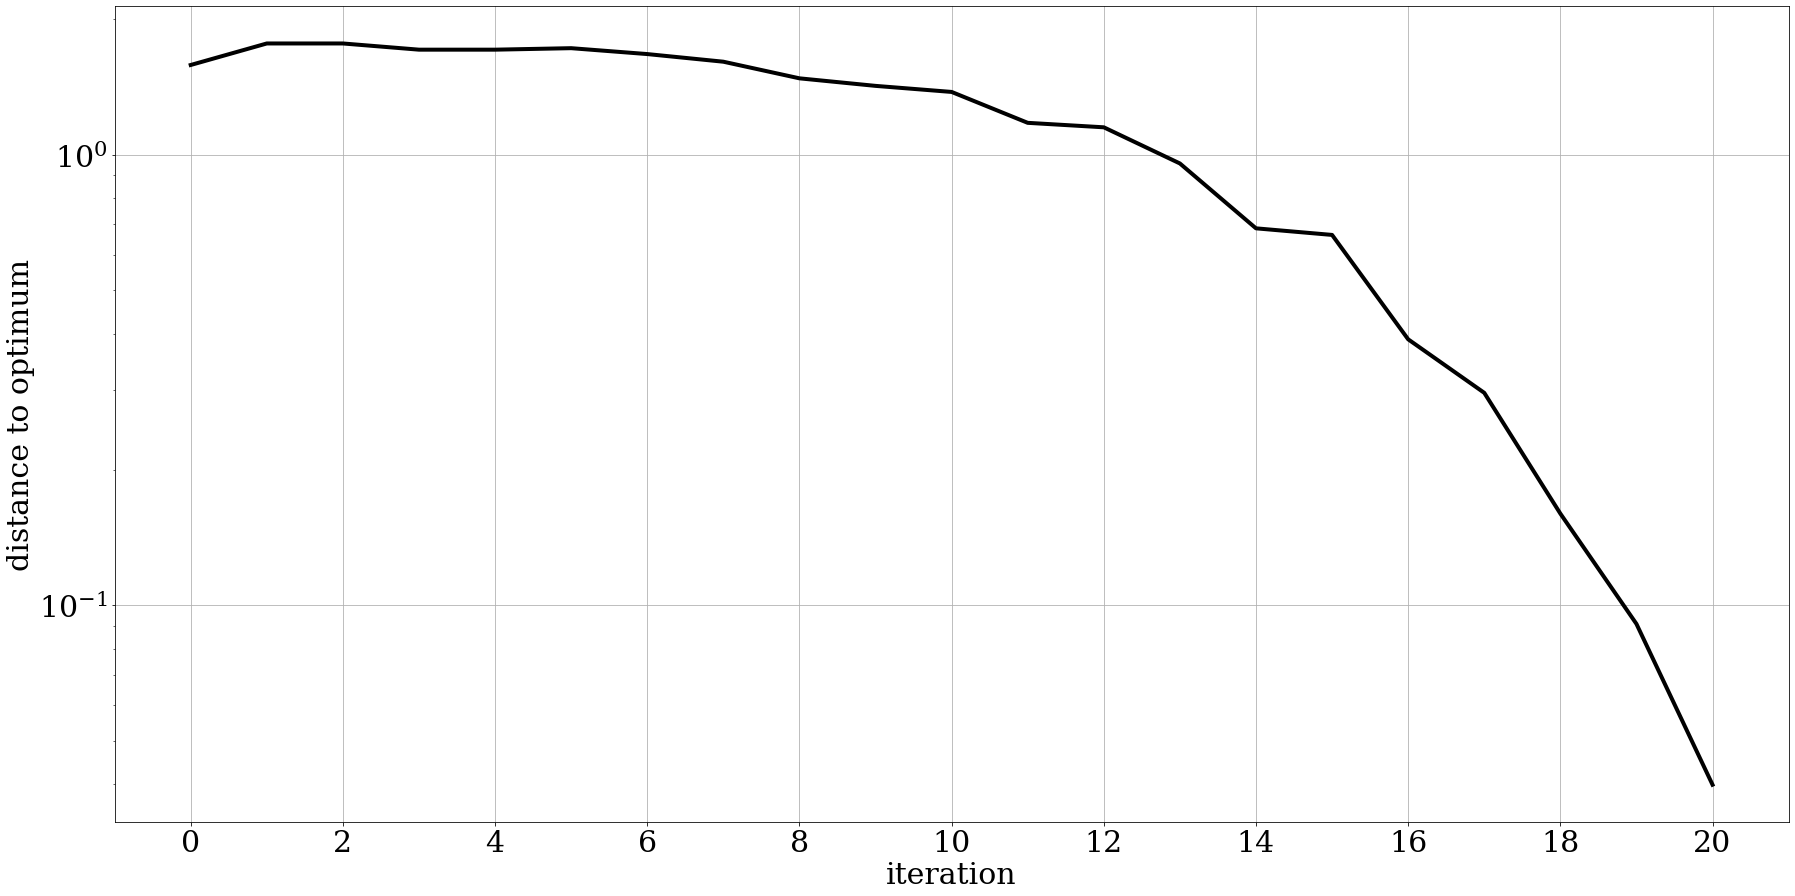

In [11]:
# Initialise coordinates and misfit. --------------------
x=np.matrix([[x0],[y0]])
chi_pr=np.zeros(nit+1)
chi_pr[0]=f.f(x[0,0],x[1,0],function)
diff_pr=np.zeros(nit+1)
diff_pr[0]=np.linalg.norm(x-opt)
plt.subplots(1, figsize=(30,15))
plt.plot(x[0,0],x[1,0],'k*',markersize=70)
if print_misfit: print('iteration=0, misfit=%f' % chi_pr[0])

s=s_min
    
# Iterate. ----------------------------------------------
for it in range(nit):
    
    if it==0:
        J=f.J(x[0,0],x[1,0],function)
        h=-J
        
    x_new, chi_pr[it+1], s_opt = line_search(x,h,s,function,ls_method)
    if s_opt==0.0: s=s/2.0
    J_new=f.J(x_new[0,0],x_new[1,0],function)
    beta=float((J_new.T*(J_new-J))/(J.T*J))
    h=-J_new+beta*h
    
    plt.plot(x_new[0,0],x_new[1,0],'ko',markersize=20)
    plt.plot((x[0,0],x_new[0,0]),(x[1,0],x_new[1,0]),'k',linewidth=4)
    
    J=J_new
    x=x_new
    
    diff_pr[it+1]=np.linalg.norm(x-opt)
        
    if print_misfit: print('iteration=%d, misfit=%f' % (it+1, chi_pr[it+1]))

# Plot trajectory. --------------------------------------
f.f(xp,yp,function,plot=True)
if save_figure==True: plt.savefig("path_cgpr.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),chi_pr,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('misfit')
plt.grid()
if save_figure==True: plt.savefig("misfit_cgpr.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),diff_pr,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('distance to optimum')
plt.grid()
if save_figure==True: plt.savefig("distance_cgpr.png",format='png')
plt.show()

## 7. Conjugate gradients (Hestenes-Stiefel)

minimum step length too long


/Users/korbinian/Applications/miniconda3/envs/mess/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


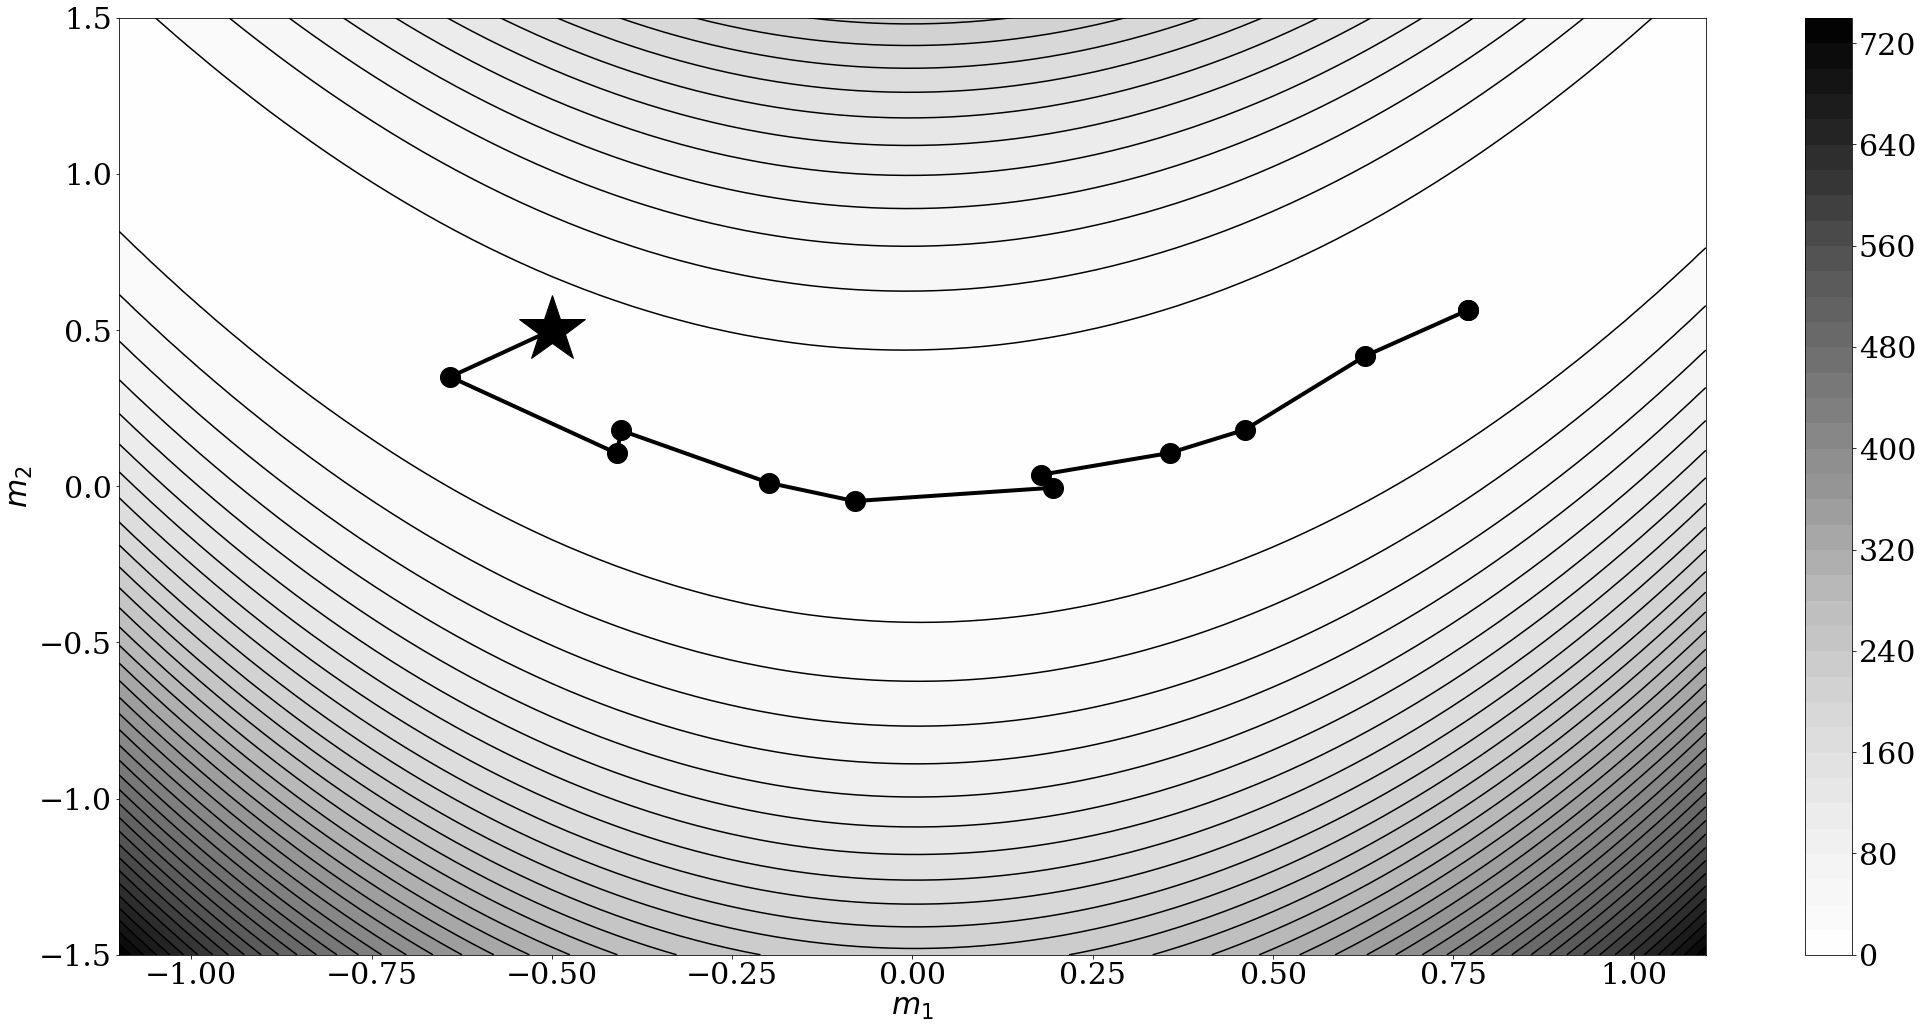

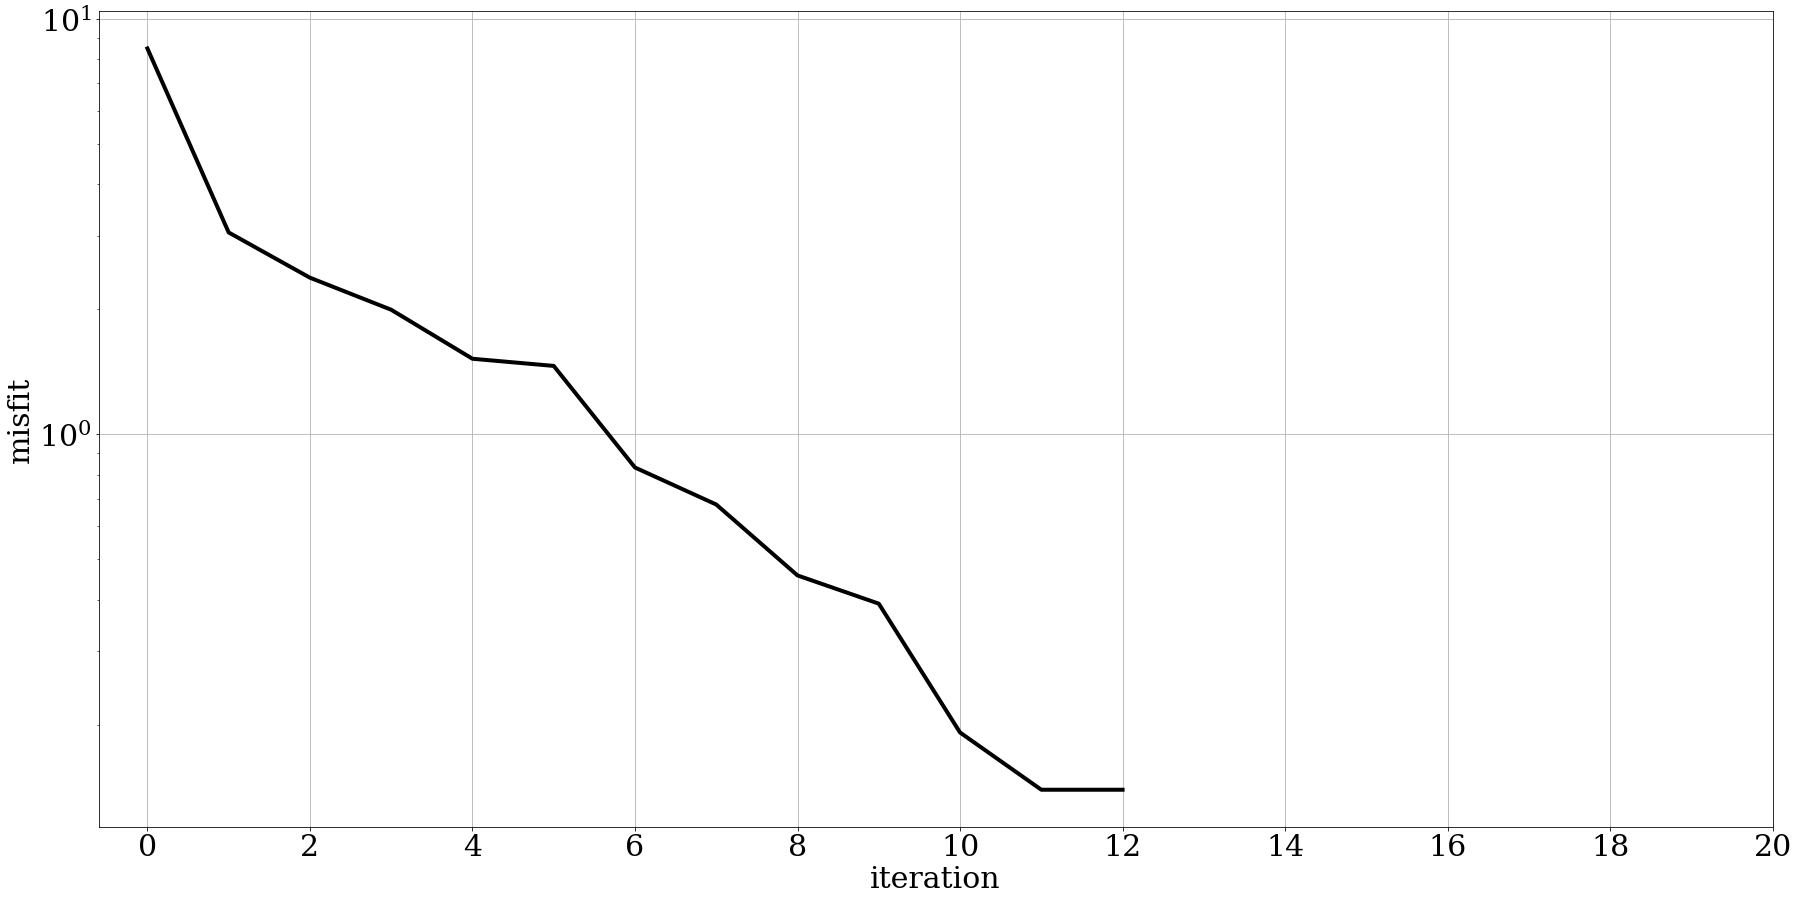

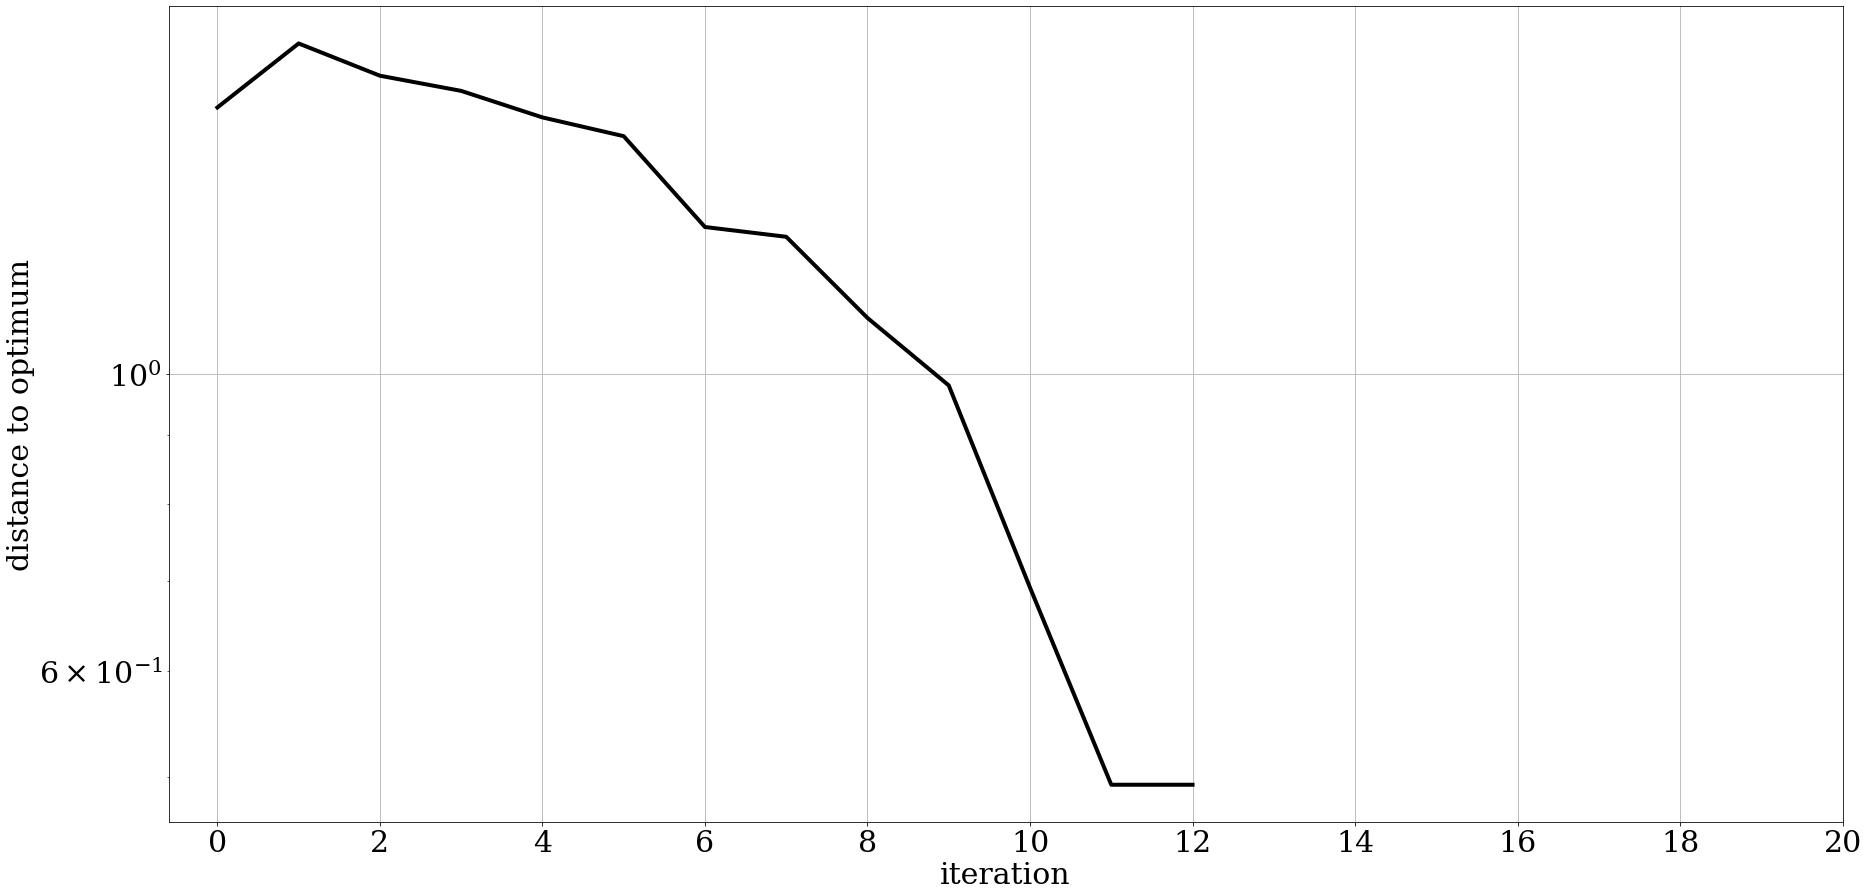

In [12]:
# Initialise coordinates and misfit. --------------------
x=np.matrix([[x0],[y0]])
chi_hs=np.zeros(nit+1)
chi_hs[0]=f.f(x[0,0],x[1,0],function)
diff_hs=np.zeros(nit+1)
diff_hs[0]=np.linalg.norm(x-opt)
plt.subplots(1, figsize=(30,15))
plt.plot(x[0,0],x[1,0],'k*',markersize=70)
if print_misfit: print('iteration=0, misfit=%f' % chi[0])

s=s_min
    
# Iterate. ----------------------------------------------
for it in range(nit):
    
    if it==0:
        J=f.J(x[0,0],x[1,0],function)
        h=-J
        
    x_new, chi_hs[it+1], s_opt = line_search(x,h,s,function,ls_method)
    if s_opt==0.0: s=s/2.0
    J_new=f.J(x_new[0,0],x_new[1,0],function)
    beta=float((J_new.T*(J_new-J))/(h.T*(J_new-J)))
    h=-J_new+beta*h
    
    plt.plot(x_new[0,0],x_new[1,0],'ko',markersize=20)
    plt.plot((x[0,0],x_new[0,0]),(x[1,0],x_new[1,0]),'k',linewidth=4)
    
    J=J_new
    x=x_new
    
    diff_hs[it+1]=np.linalg.norm(x-opt)
        
    if print_misfit: print('iteration=%d, misfit=%f' % (it+1, chi_hs[it+1]))

# Plot trajectory. --------------------------------------
f.f(xp,yp,function,plot=True)
if save_figure==True: plt.savefig("path_cghs.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),chi_hs,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('misfit')
plt.grid()
if save_figure==True: plt.savefig("misfit_cghs.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),diff_hs,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('distance to optimum')
plt.grid()
if save_figure==True: plt.savefig("distance_cghs.png",format='png')
plt.show()

## 8. BFGS

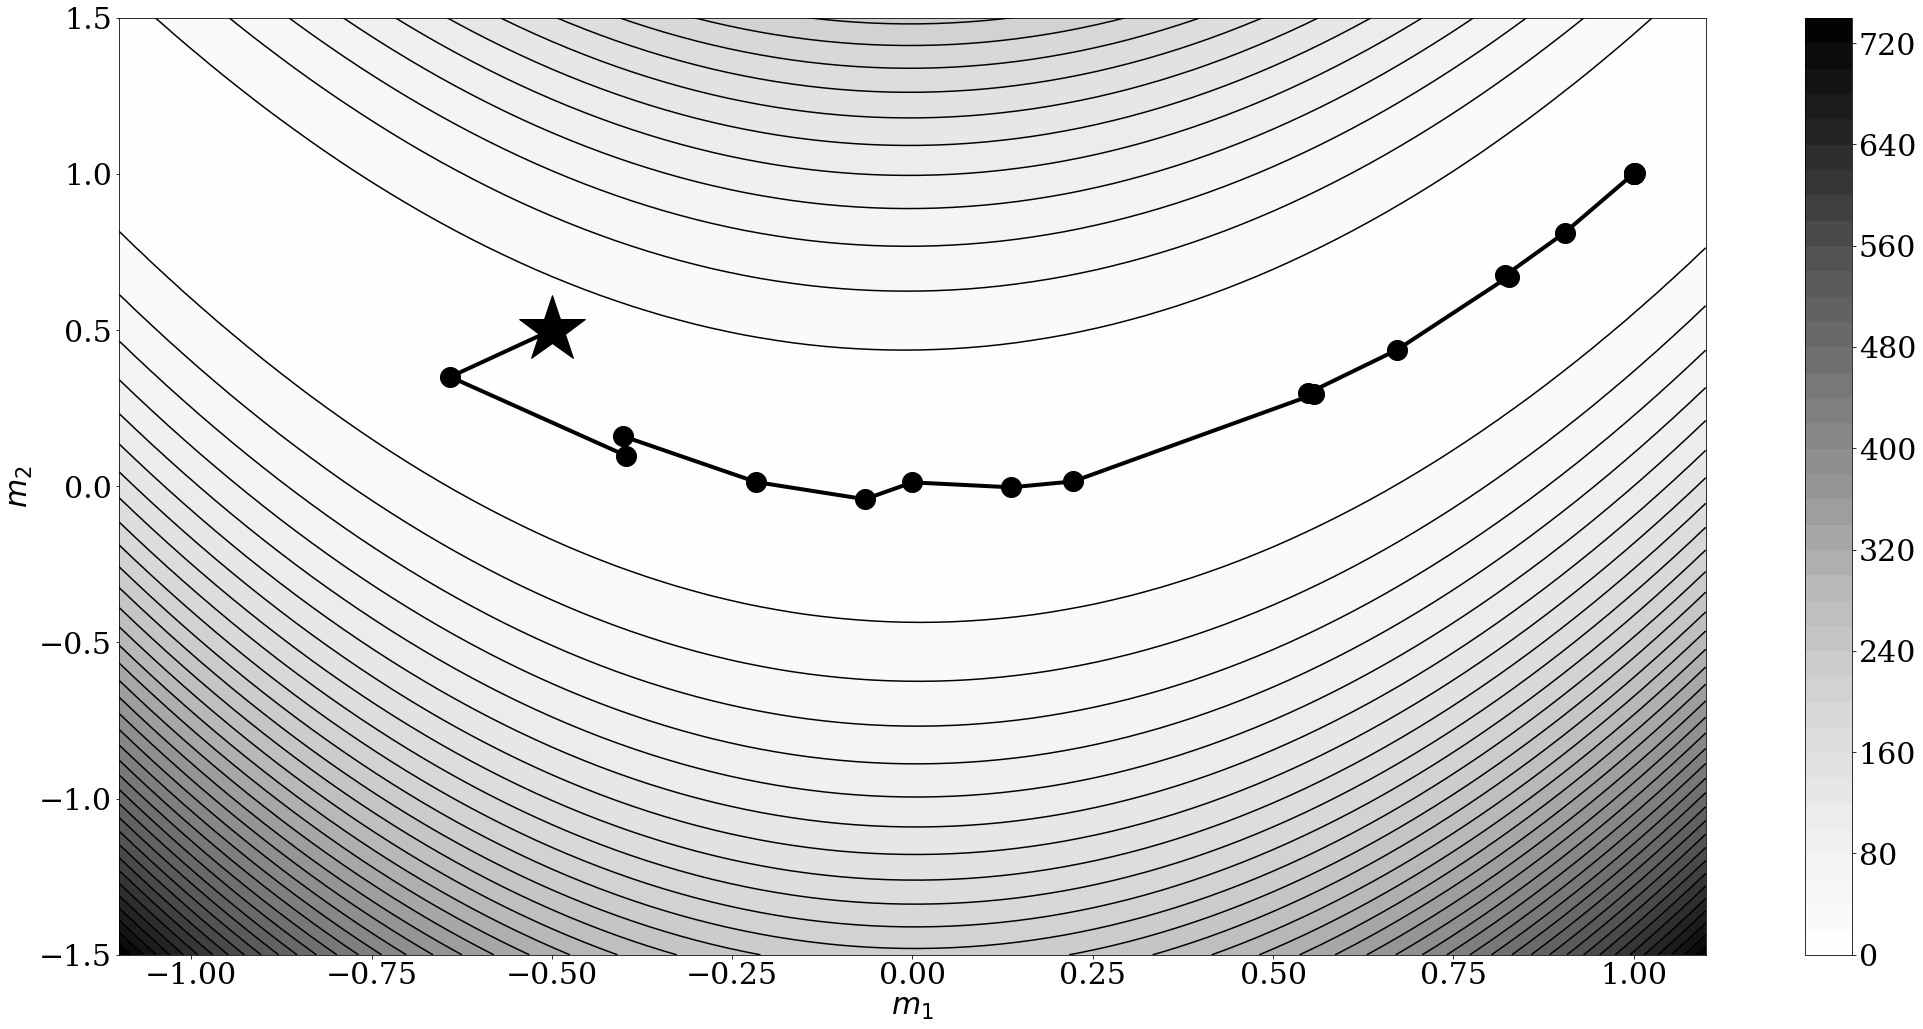

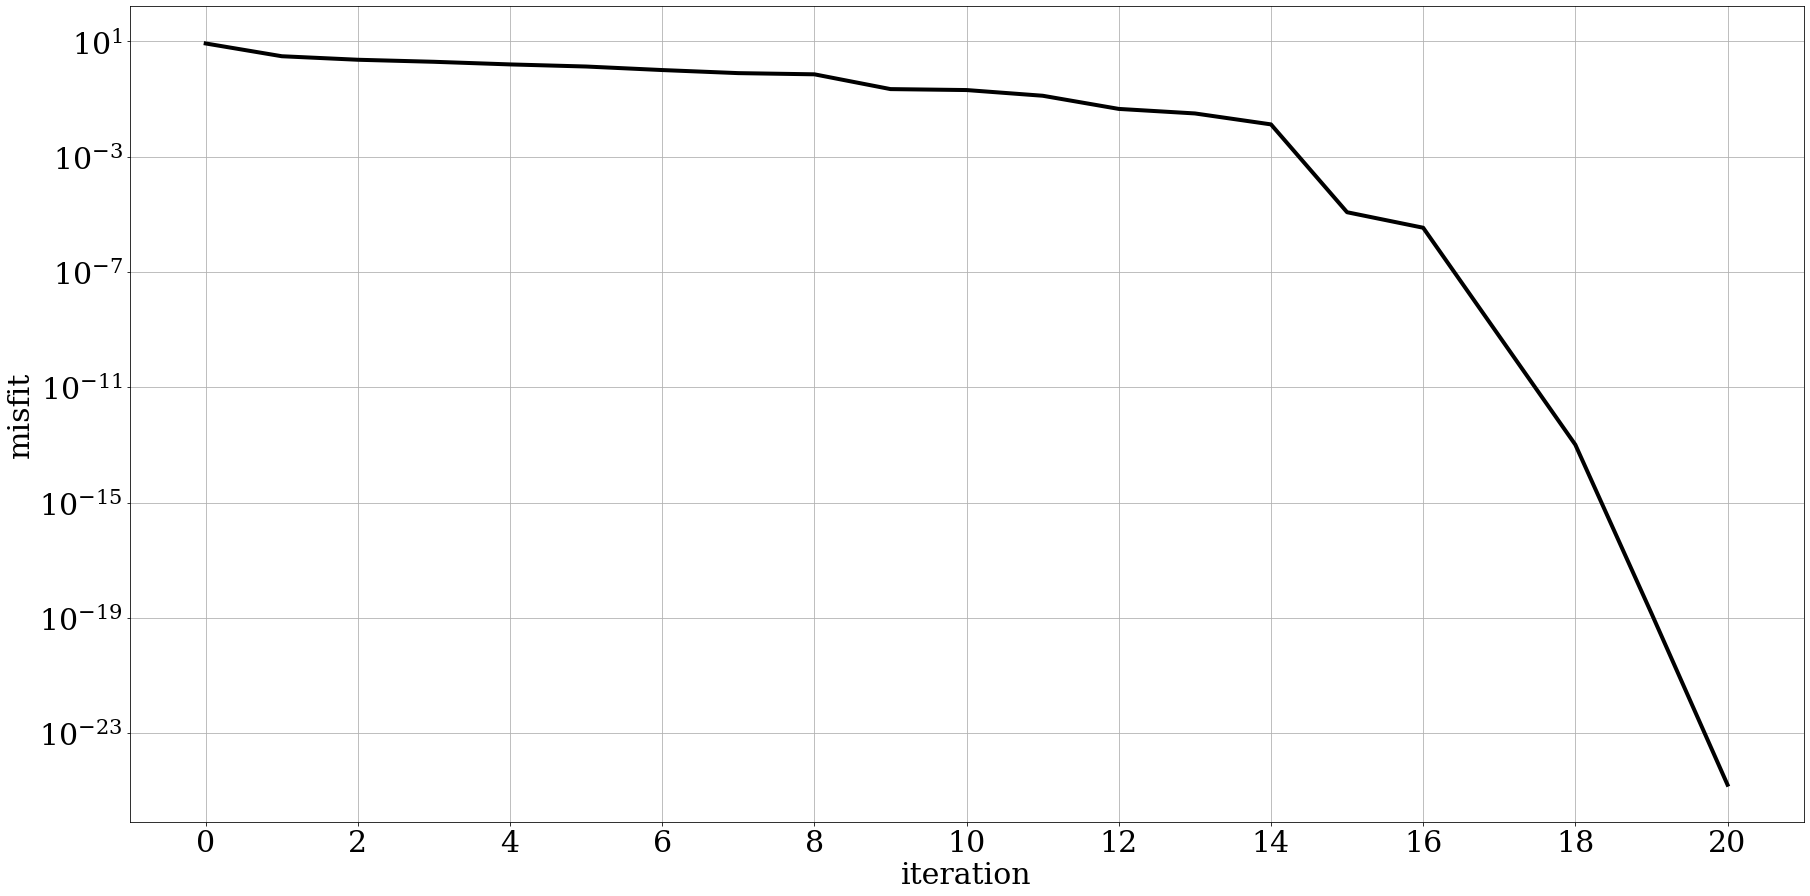

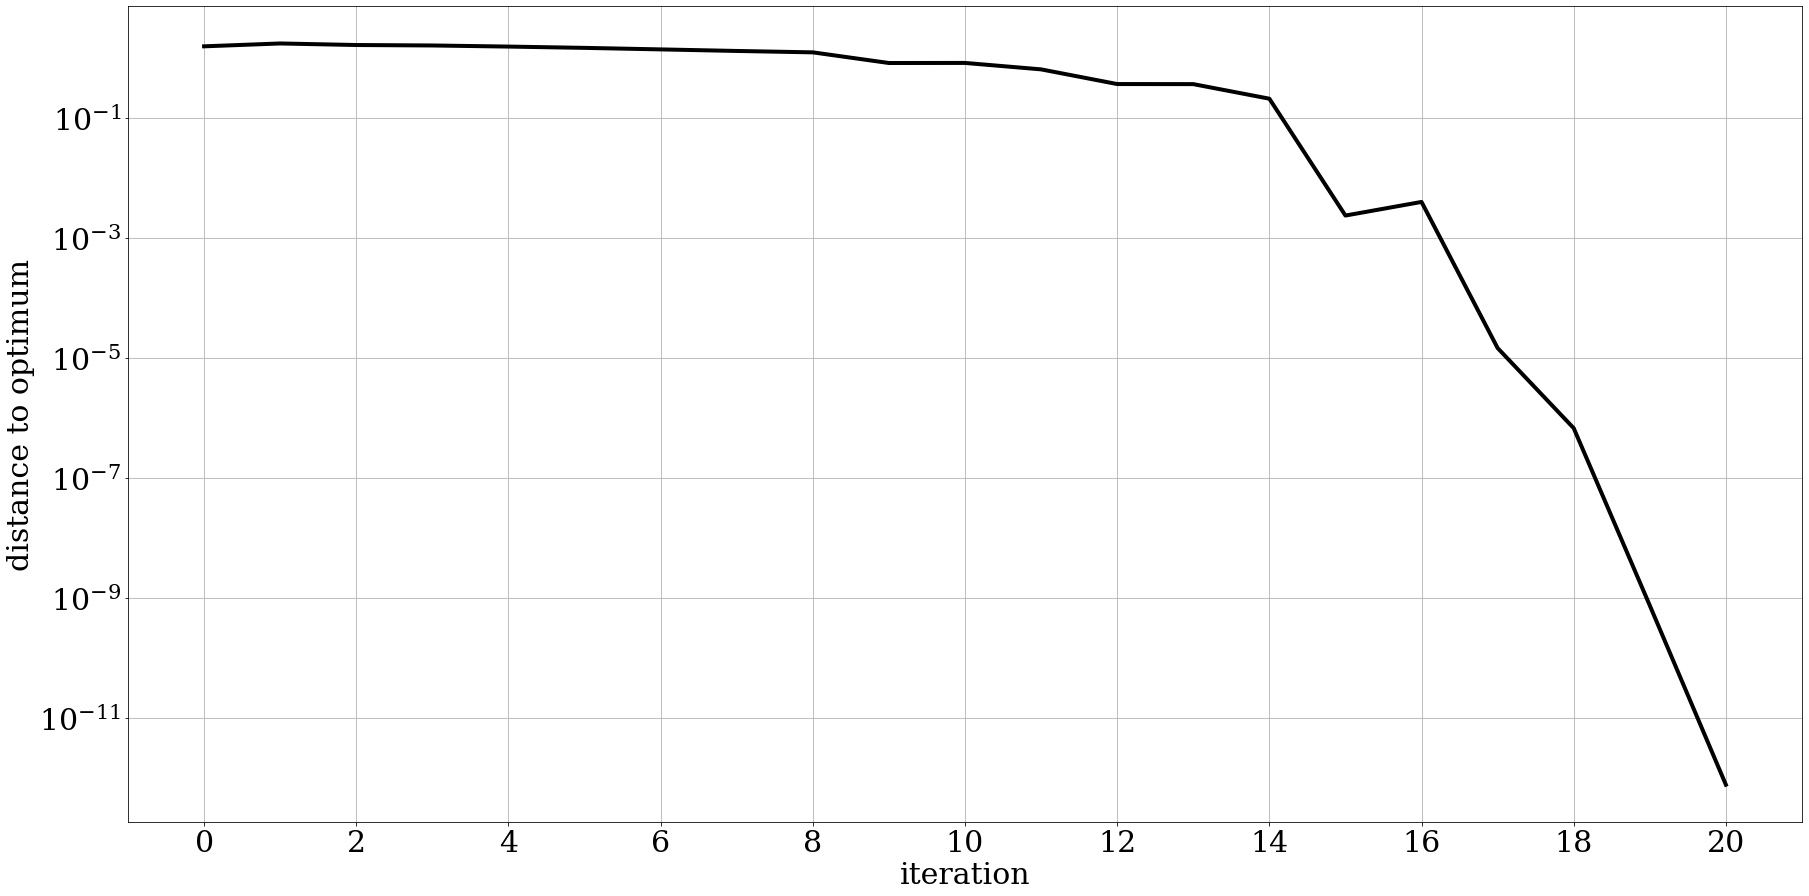

exact inverse Hessian in the final iteration:
[[ 802. -400.]
 [-400.  200.]]
approximate inverse Hessian in the final iteration
[[ 801.96828539 -399.9837531 ]
 [-399.9837531   199.99167697]]


In [13]:
# Initialise coordinates and misfit. --------------------
x=np.matrix([[x0],[y0]])
A=np.identity(2)
I=np.identity(2)
chi_bfgs=np.zeros(nit+1)
chi_bfgs[0]=f.f(x[0,0],x[1,0],function)
diff_bfgs=np.zeros(nit+1)
diff_bfgs[0]=np.linalg.norm(x-opt)
plt.subplots(1, figsize=(30,15))
plt.plot(x[0,0],x[1,0],'k*',markersize=70)
if print_misfit: print('iteration=0, misfit=%f' % chi[0])

s=s_min
    
# Iterate. ----------------------------------------------
for it in range(nit):
    
    # Compute descent direction.
    J=f.J(x[0,0],x[1,0],function)
    h=-A*J
        
    # Compute update of position and of gradient
    x_new, chi_bfgs[it+1], s_opt = line_search(x,h,s,function,ls_method)
    if s_opt==0.0: s=s/2.0
    J_new=f.J(x_new[0,0],x_new[1,0],function)
    
    # Compute position and gradient differences.
    b=x_new-x
    y=J_new-J
    
    # Update the matrix A.
    rho=float(1.0/(y.T*b))
    A=(I-rho*b*y.T)*A*(I-rho*y*b.T)+rho*b*b.T
    
    # Plot next step of the trajectory.
    plt.plot(x_new[0,0],x_new[1,0],'ko',markersize=20)
    plt.plot((x[0,0],x_new[0,0]),(x[1,0],x_new[1,0]),'k',linewidth=4)
    
    # Move position and gradient to the next iteration.
    J=J_new
    x=x_new
    
    diff_bfgs[it+1]=np.linalg.norm(x-opt)
        
    if print_misfit: print('iteration=%d, misfit=%f' % (it+1, chi_bfgs[it+1]))

# Plot trajectory. --------------------------------------
f.f(xp,yp,function,plot=True)
if save_figure==True: plt.savefig("path_bfgs.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),chi_bfgs,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('misfit')
plt.grid()
if save_figure==True: plt.savefig("misfit_bfgs.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),diff_bfgs,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('distance to optimum')
plt.grid()
if save_figure==True: plt.savefig("distance_bfgs.png",format='png')
plt.show()

# Print correct and approximate inverse Hessians.
print('exact inverse Hessian in the final iteration:')
print(f.H(x[0,0],x[1,0],function))
print('approximate inverse Hessian in the final iteration')
print(np.linalg.inv(A))

## 9. L-BFGS

The L-BFGS method requires a little bit more algorithmic overhead. Before going to the iteration itself, we provide a Python class that stores the $k$ most recent vector pairs and performs the internal L-BFGS iterations to compute the negative descent direction.

In [14]:
class lbfgs:
    
    def __init__(self,k):
        """
        Initialise the BFGS class with zero vectors.
        
        :param k: Maximum number of vectors.
        """
        
        self.k=k # Maximum number of vectors.
        self.i=0 # Currently stored vectors.
        self.s=np.zeros((2,k)) # s vectors.
        self.y=np.zeros((2,k)) # y vectors.
        
    def put(self,s,y):
        """
        Update the stored vector pairs.
        
        :param s: New s vector.
        :param y: New y vector.
        """
        
        # When less then k vector pairs are stored, we increase the index of stored pairs and add the new pair.
        if self.i<self.k:
            self.i+=1
        # Otherwise we kick out the pair with the lowest index by rolling to the left and over-writing the last pair.
        else:
            self.s=np.roll(self.s, -1, axis=1)
            self.y=np.roll(self.y, -1, axis=1)
        
        self.s[:,self.i-1]=s
        self.y[:,self.i-1]=y
        
    def iterate(self,q):
        """
        Perform the 2 internal L-BFGS iterations.
        
        :param q: Current gradient vector.
        """
        
        # Iteration 1. -------------------------------------
        alpha=np.zeros(self.i)
        A0=np.identity(2)
        
        for n in range(self.i-1,-1,-1):
            rho=1.0/np.dot(self.y[:,n],self.s[:,n])
            alpha[n]=rho*np.dot(self.s[:,n],q)
            q=q-alpha[n]*self.y[:,n]
       
        r=np.dot(A0,q)
        
        # Iteration 2. -------------------------------------
        for n in range(0,self.i):
            rho=1.0/np.dot(self.y[:,n],self.s[:,n])
            beta=rho*np.dot(self.y[:,n],r)
            r=r+(alpha[n]-beta)*self.s[:,n]
        
        # Return the negative descent direction.
        return r

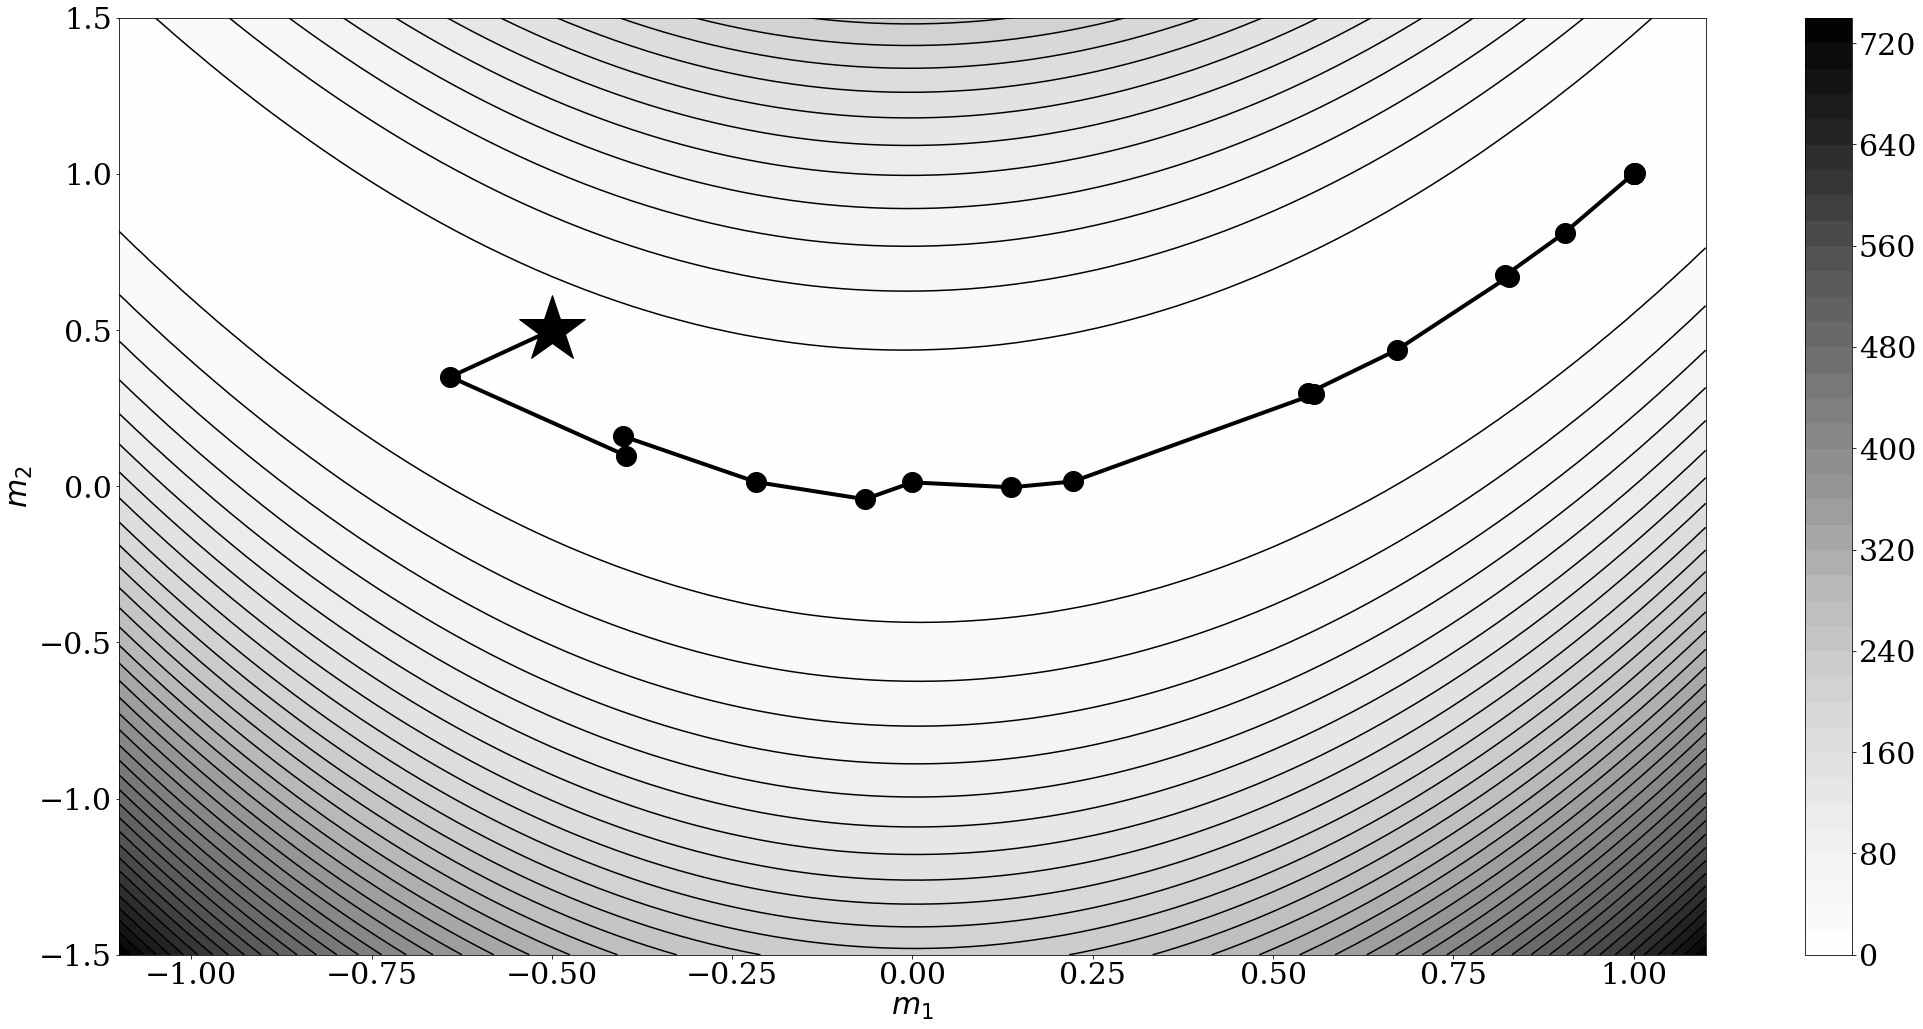

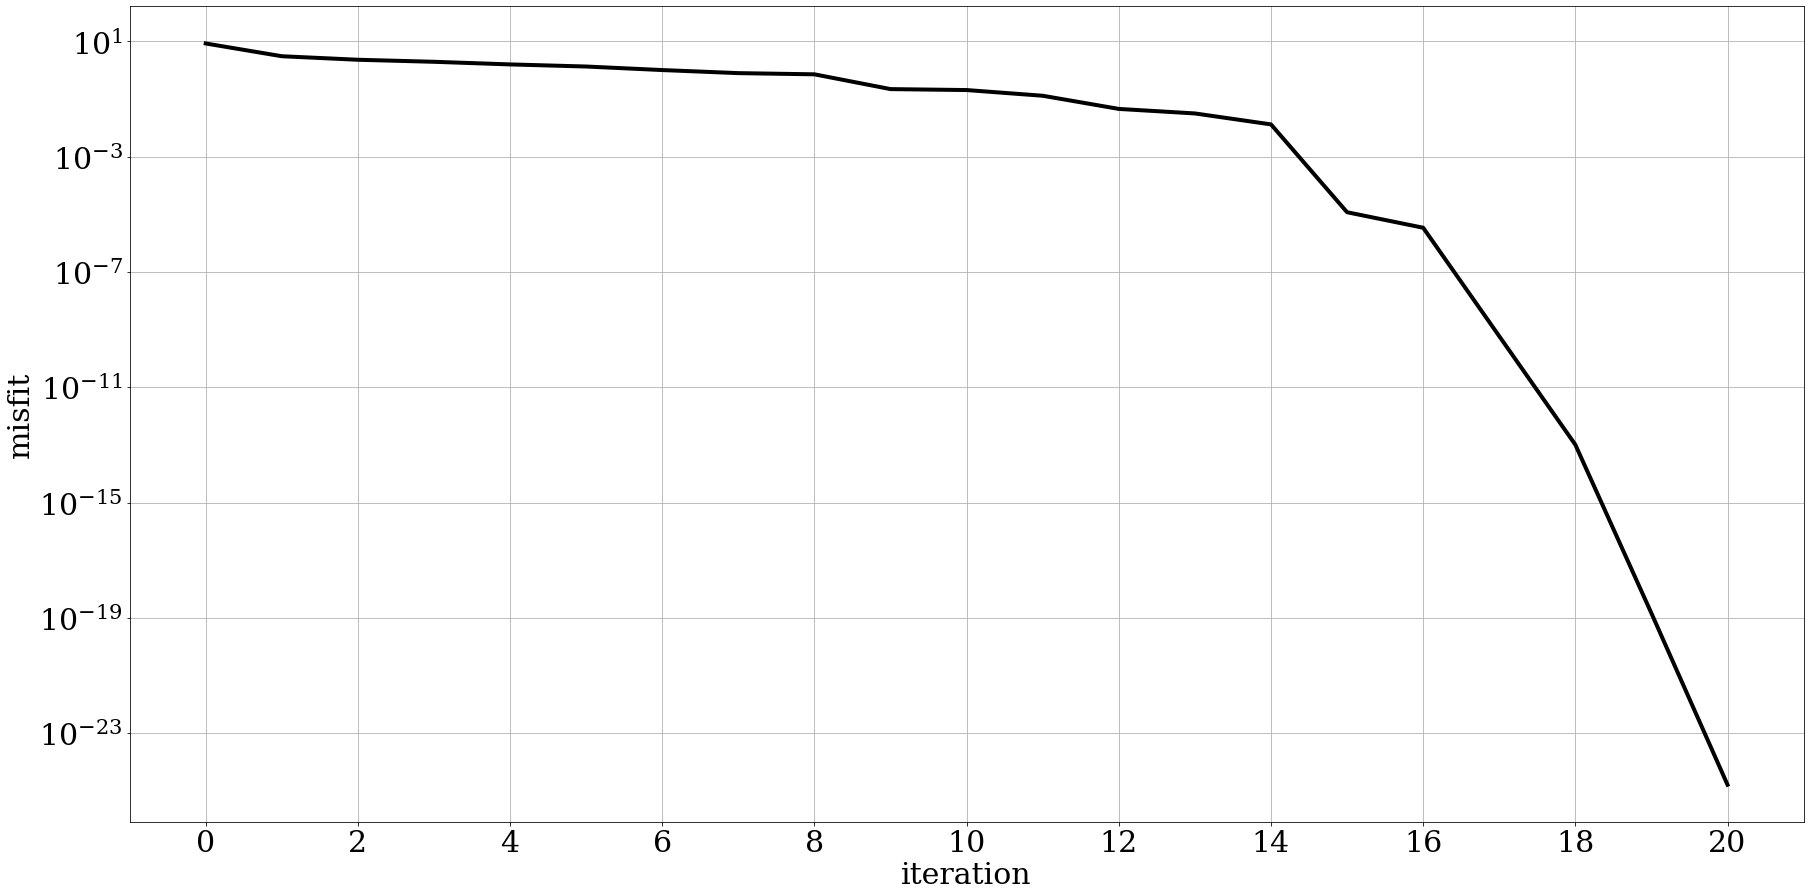

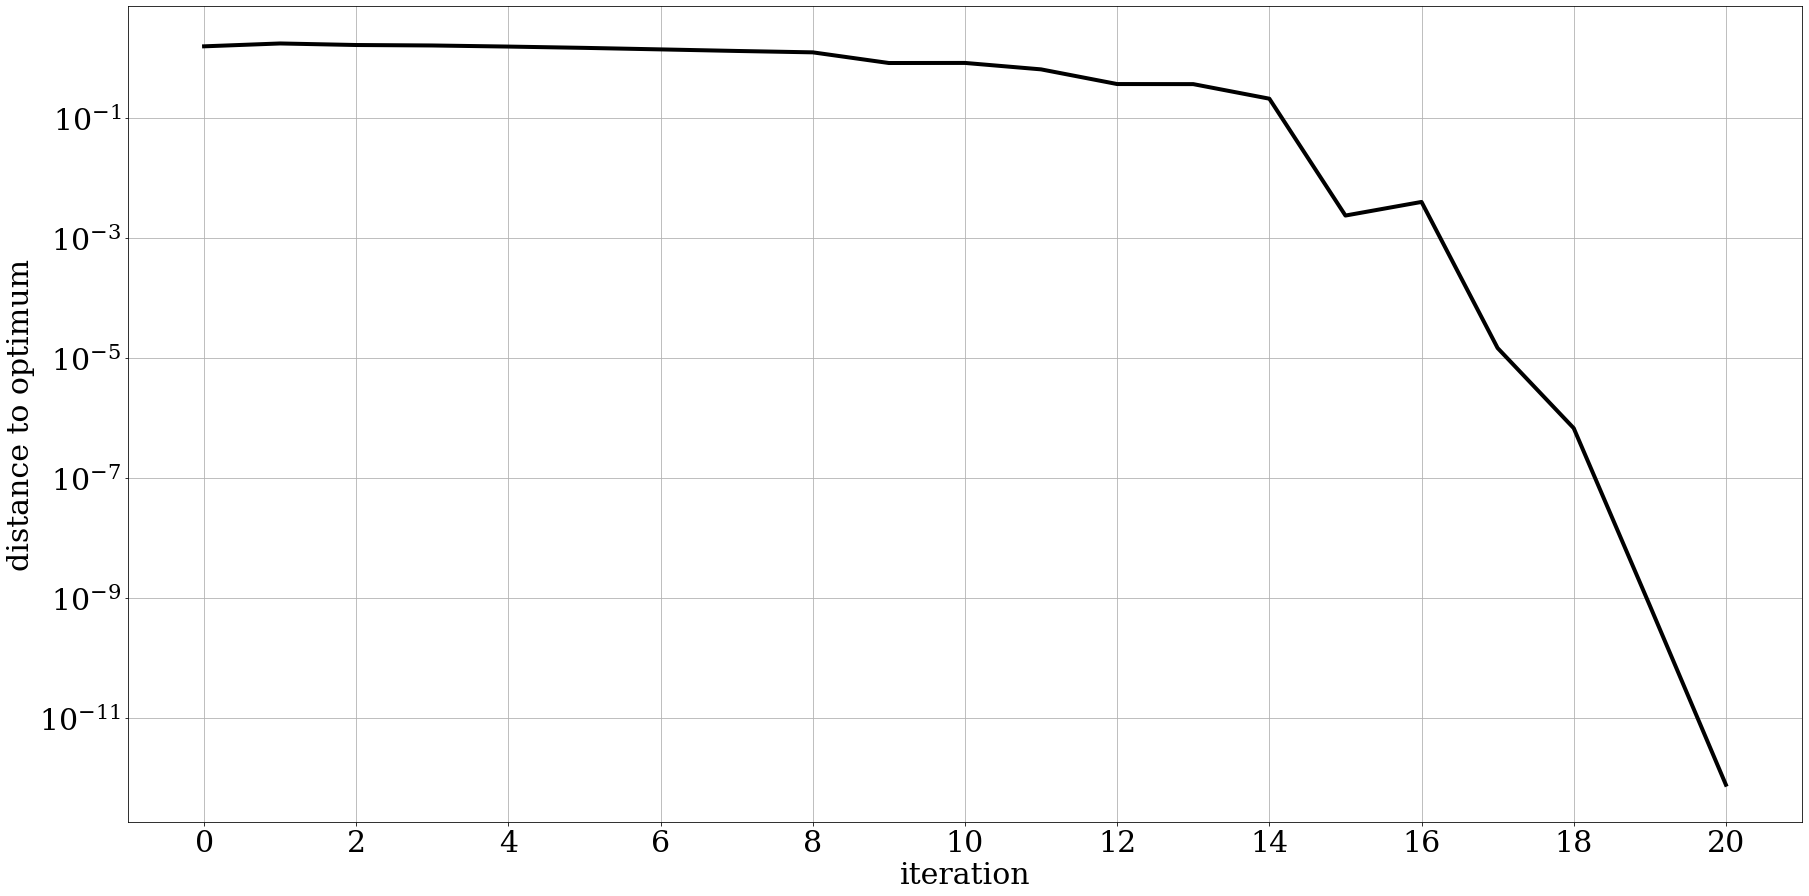

In [15]:
# Initialise coordinates and misfit. --------------------
x=np.matrix([[x0],[y0]])
chi_lbfgs=np.zeros(nit+1)
chi_lbfgs[0]=f.f(x[0,0],x[1,0],function)
diff_lbfgs=np.zeros(nit+1)
diff_lbfgs[0]=np.linalg.norm(x-opt)
plt.subplots(1, figsize=(30,15))
plt.plot(x[0,0],x[1,0],'k*',markersize=70)
if print_misfit: print('iteration=0, misfit=%f' % chi_lbfgs[0])

L=lbfgs(5)

s=s_min

# Iterate. ----------------------------------------------
for it in range(nit):
    
    # Compute descent direction.
    J=f.J(x[0,0],x[1,0],function)
    if it==0:
        h=-J
    else:
        h=-L.iterate(np.ravel(J))
        h=np.reshape(h,(2,1))
       
    # Compute update of position and of gradient
    x_new, chi_lbfgs[it+1], s_opt = line_search(x,h,s,function,ls_method)
    if s_opt==0.0: s=s/2.0
    J_new=f.J(x_new[0,0],x_new[1,0],function)
    
    # Compute position and gradient differences.
    b=x_new-x
    y=J_new-J
    
    # Update the set of vector pairs.
    L.put(np.ravel(b),np.ravel(y))
    
    # Plot next step of the trajectory.
    plt.plot(x_new[0,0],x_new[1,0],'ko',markersize=20)
    plt.plot((x[0,0],x_new[0,0]),(x[1,0],x_new[1,0]),'k',linewidth=4)
    
    # Move position and gradient to the next iteration.
    J=J_new
    x=x_new
    
    diff_lbfgs[it+1]=np.linalg.norm(x-opt)
        
    if print_misfit: print('iteration=%d, misfit=%f' % (it+1, chi_lbfgs[it+1]))

# Plot trajectory. --------------------------------------
f.f(xp,yp,function,plot=True)
if save_figure==True: plt.savefig("path_lbfgs.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),chi_lbfgs,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('misfit')
plt.grid()
if save_figure==True: plt.savefig("misfit_lbfgs.png",format='png')
plt.show()

plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),diff_lbfgs,'k',linewidth=4)
plt.xticks(np.arange(0,nit+1,2))
plt.xlabel('iteration')
plt.ylabel('distance to optimum')
plt.grid()
if save_figure==True: plt.savefig("distance_lbfgs.png",format='png')
plt.show()

## 10. Convergence summary

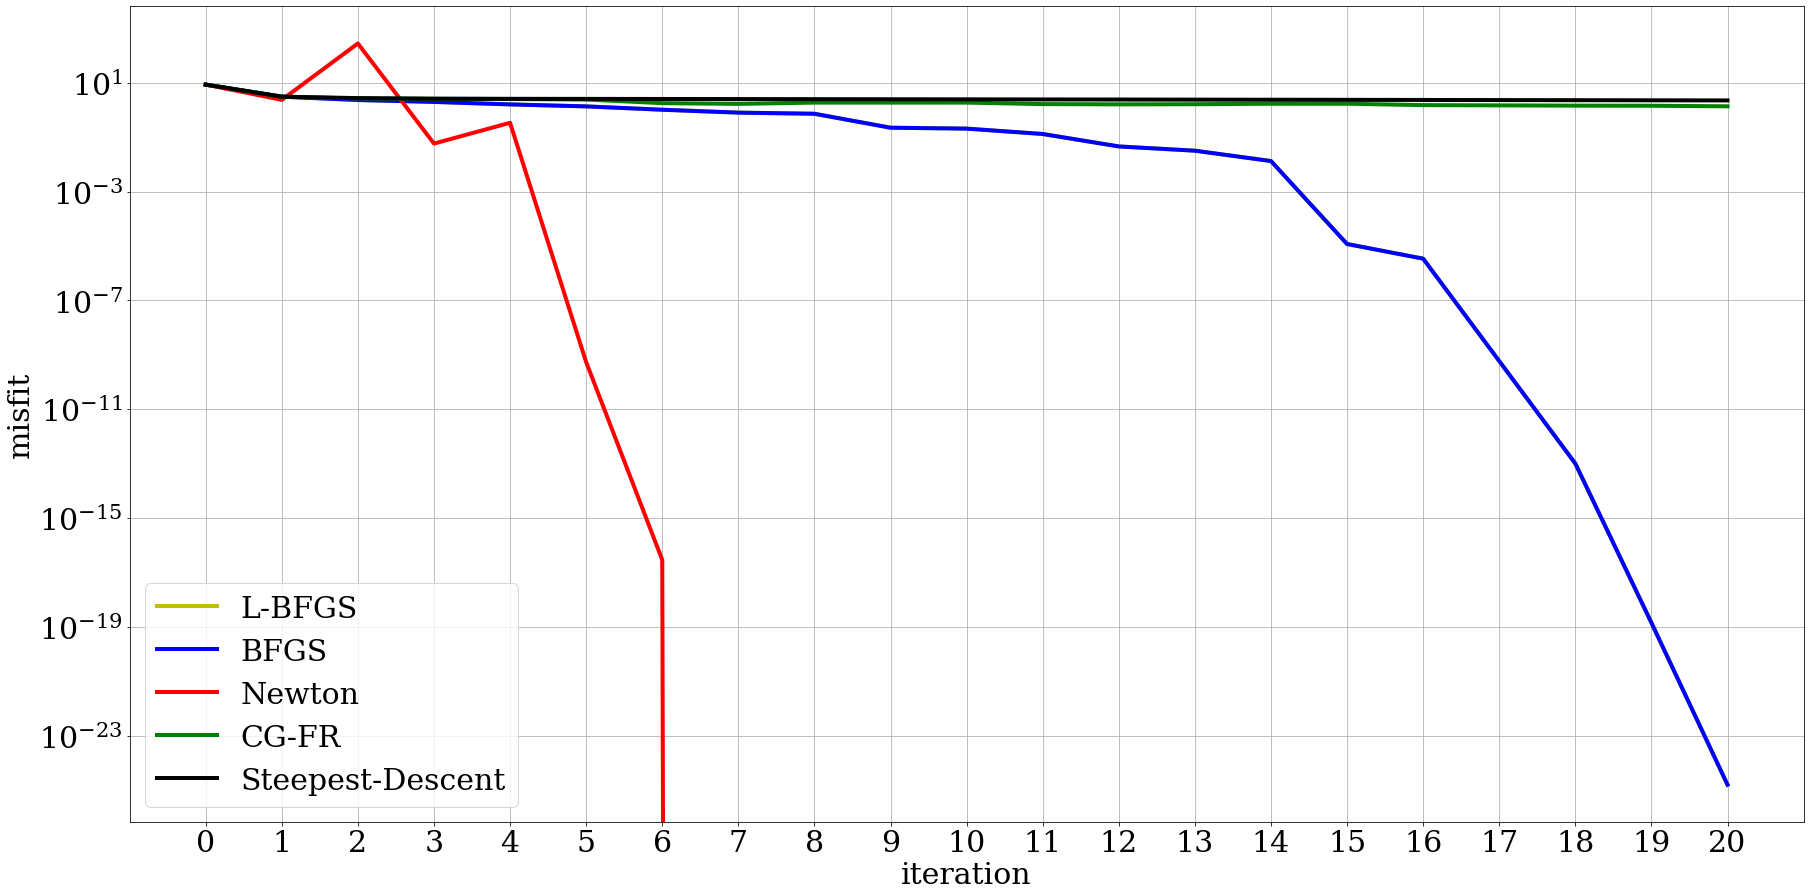

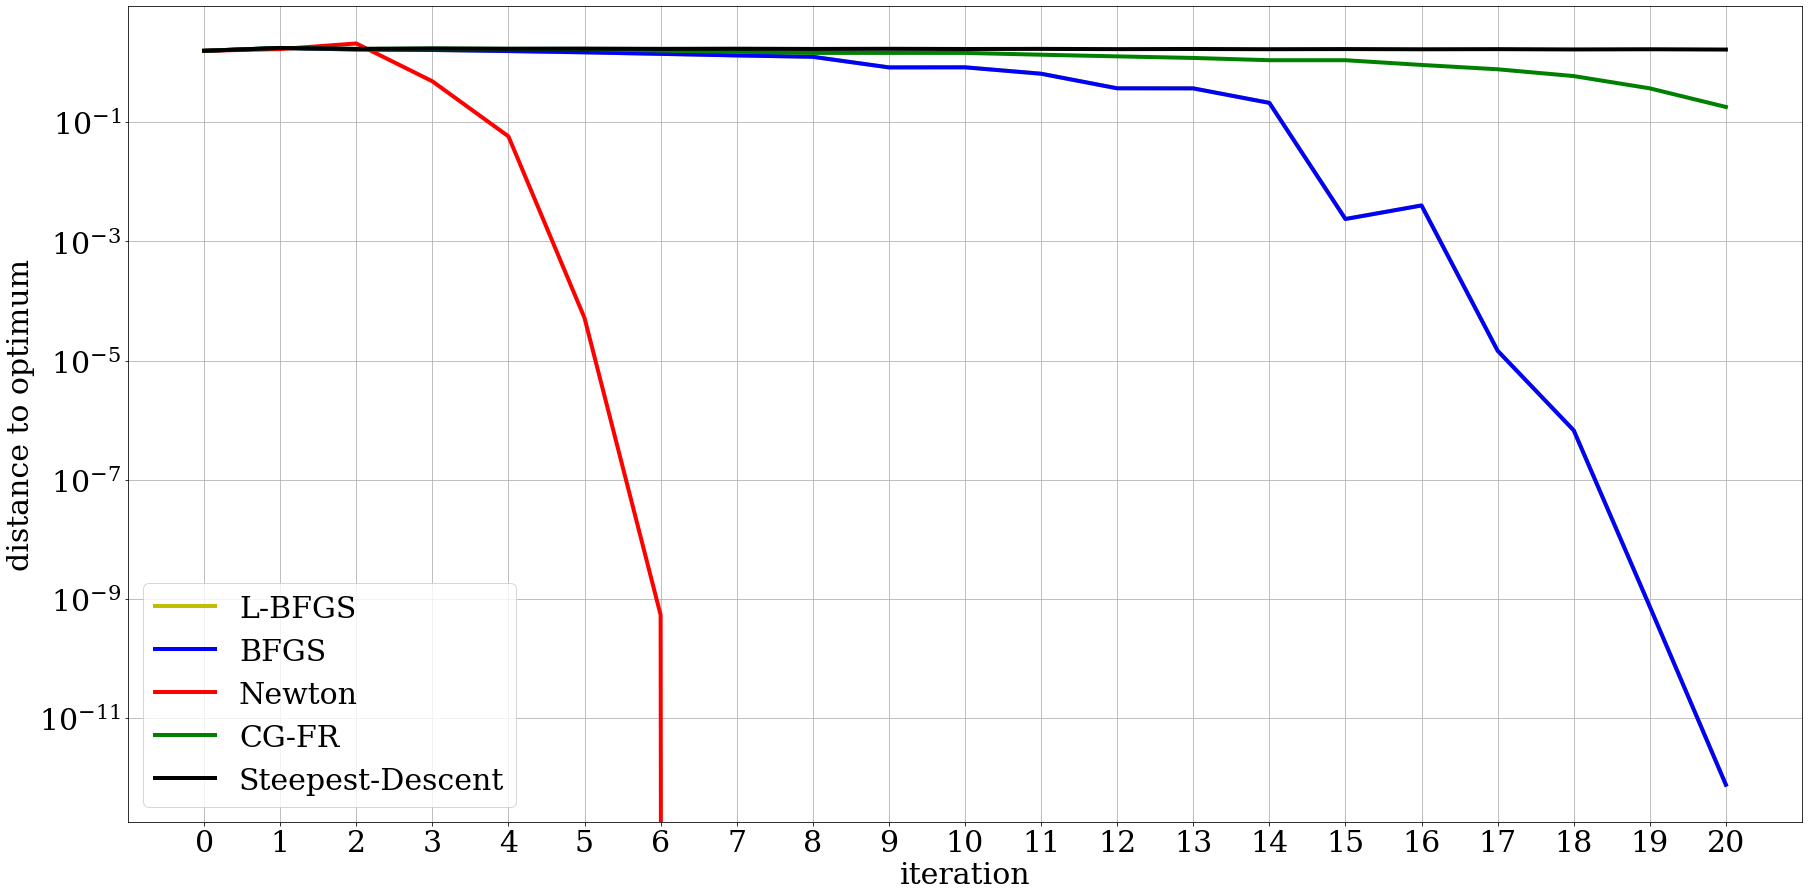

In [16]:
# Misfit
plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),chi_lbfgs,'y',label='L-BFGS',linewidth=4)
plt.semilogy(np.arange(0,nit+1),chi_bfgs,'b',label='BFGS',linewidth=4)
plt.semilogy(np.arange(0,nit+1),chi_ne,'r',label='Newton',linewidth=4)
plt.semilogy(np.arange(0,nit+1),chi_fr,'g',label='CG-FR',linewidth=4)
plt.semilogy(np.arange(0,nit+1),chi_sd,'k',label='Steepest-Descent',linewidth=4)

plt.legend()
plt.xticks(np.arange(0,nit+1))
plt.xlabel('iteration')
plt.ylabel('misfit')
plt.grid()
if save_figure==True: plt.savefig("comparison_misfits.png",format='png')
plt.show()

#Distance to optimum
plt.subplots(1, figsize=(30,15))
plt.semilogy(np.arange(0,nit+1),diff_lbfgs,'y',label='L-BFGS',linewidth=4)
plt.semilogy(np.arange(0,nit+1),diff_bfgs,'b',label='BFGS',linewidth=4)
plt.semilogy(np.arange(0,nit+1),diff_ne,'r',label='Newton',linewidth=4)
plt.semilogy(np.arange(0,nit+1),diff_fr,'g',label='CG-FR',linewidth=4)
plt.semilogy(np.arange(0,nit+1),diff_sd,'k',label='Steepest-Descent',linewidth=4)

plt.legend()
plt.xticks(np.arange(0,nit+1))
plt.xlabel('iteration')
plt.ylabel('distance to optimum')
plt.grid()
if save_figure==True: plt.savefig("comparison_distance.png",format='png')
plt.show()